In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import time
import easydict
import copy

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, LinearLR

from time_transformer.transformer import Transformer
from time_transformer.utils_valid_loss_point import compute_val_point_score

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def new_mape(y_true, y_pred, max_val):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max_val)) * 100

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path= r"C:\Users\sashah8\DOE_Graph_Attention_Transformer\DOE MODEL TRAINING\Data Processing\processed_data"
dataset = "L3"

# Listing just the required files
fileList = os.listdir(os.path.join(path, dataset))

# Previewing the required file names
print(fileList)

['AT.csv', 'BE.csv', 'BG.csv', 'CH.csv', 'CZ.csv', 'DK.csv', 'ES.csv', 'FR.csv', 'GR.csv', 'IT.csv', 'NL.csv', 'PT.csv', 'SI.csv', 'SK.csv']


In [3]:
# Just for previewing the column name
display(pd.read_csv(os.path.join(path, dataset, fileList[0])).head(2))

,ept,mw,tmp
0,2015-01-01 00:00:00,5946,-6.503
1,2015-01-01 01:00:00,5726,-6.458


In [4]:
# Just for previewing the column name
data = pd.read_csv(os.path.join(path, dataset, fileList[0]), parse_dates=['ept'])
print("Sample dataframe: ")
display(data.head(2))

Sample dataframe: 


,ept,mw,tmp
0,2015-01-01 00:00:00,5946,-6.503
1,2015-01-01 01:00:00,5726,-6.458


In [5]:
# Fetching the date column only
date_col = data.ept.copy()
date_col.name = "AA_ept"
date_col.head(2)

0   2015-01-01 00:00:00
1   2015-01-01 01:00:00
Name: AA_ept, dtype: datetime64[ns]

In [6]:
# Creating the calendar features
date = pd.DataFrame()
date['Month'] = date_col.dt.month
date['Day'] = date_col.dt.day
date['Hour'] = date_col.dt.hour
date['Weekday'] = date_col.dt.weekday

print("Sample calendar features: ")
display(date.head(2))

print("Available unique categories: ")
display(date.nunique())

print("Total number of observations: ", len(date))

Sample calendar features: 


,Month,Day,Hour,Weekday
0,1,1,0,3
1,1,1,1,3


Available unique categories: 


Month      12
Day        31
Hour       24
Weekday     7
dtype: int64

Total number of observations:  43824


In [7]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
display(categorical_data)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 24, 7]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [9]:
# Fetching and concatenating the data
load_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["mw"]) for fileName in fileList], axis= 1)
load_ds.columns = [i.removesuffix('.csv') for i in fileList]
load_ds = load_ds.add_suffix("_A_LOAD")
display(load_ds.tail(2))

,AT_A_LOAD,BE_A_LOAD,BG_A_LOAD,CH_A_LOAD,CZ_A_LOAD,DK_A_LOAD,ES_A_LOAD,FR_A_LOAD,GR_A_LOAD,IT_A_LOAD,NL_A_LOAD,PT_A_LOAD,SI_A_LOAD,SK_A_LOAD
43822,6206,9392,4410.0,6451.50,5822.73,3309.25,23911.0,65865.0,5657.63,23876.0,11418,5484.7,1134.03,2980.0
43823,5967,9069,4243.0,6891.33,5611.71,3315.91,22963.0,64677.0,5337.38,22510.0,11215,5243.8,1086.73,2814.0


In [10]:
lag_24_ahead = True

# Creating 1-day lag loads
if lag_24_ahead:
    lag_val = 1
else:
    lag_val = 2

load_lag_1 = load_ds.shift(24*lag_val).add_suffix("_LAG1")
display(load_lag_1.tail(2))

,AT_A_LOAD_LAG1,BE_A_LOAD_LAG1,BG_A_LOAD_LAG1,CH_A_LOAD_LAG1,CZ_A_LOAD_LAG1,DK_A_LOAD_LAG1,ES_A_LOAD_LAG1,FR_A_LOAD_LAG1,GR_A_LOAD_LAG1,IT_A_LOAD_LAG1,NL_A_LOAD_LAG1,PT_A_LOAD_LAG1,SI_A_LOAD_LAG1,SK_A_LOAD_LAG1
43822,6348.0,9480.0,4651.0,6855.91,6307.43,3469.41,26713.0,68149.0,5589.98,24969.0,12082.0,6317.3,1196.59,3002.0
43823,6021.0,9008.0,4393.0,6654.80,6009.63,3266.57,24230.0,65601.0,5025.98,22079.0,11453.0,5800.2,1105.00,2866.0


In [11]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
display(load_lag_7.tail(2))

,AT_A_LOAD_LAG7,BE_A_LOAD_LAG7,BG_A_LOAD_LAG7,CH_A_LOAD_LAG7,CZ_A_LOAD_LAG7,DK_A_LOAD_LAG7,ES_A_LOAD_LAG7,FR_A_LOAD_LAG7,GR_A_LOAD_LAG7,IT_A_LOAD_LAG7,NL_A_LOAD_LAG7,PT_A_LOAD_LAG7,SI_A_LOAD_LAG7,SK_A_LOAD_LAG7
43822,5748.0,8691.0,3734.0,6645.40,5437.48,3194.35,21541.0,55237.0,4764.68,22415.0,11622.0,4814.1,1074.13,2641.0
43823,5444.0,8365.0,3510.0,7093.08,5087.48,3117.52,20946.0,53648.0,4337.98,20677.0,11243.0,4683.2,996.82,2557.0


In [12]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis= 0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


PROCESSING TEMPERATURE DATA

In [13]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["tmp"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")
display(temp_ds.tail(2))

,AT_A_TEMP,BE_A_TEMP,BG_A_TEMP,CH_A_TEMP,CZ_A_TEMP,DK_A_TEMP,ES_A_TEMP,FR_A_TEMP,GR_A_TEMP,IT_A_TEMP,NL_A_TEMP,PT_A_TEMP,SI_A_TEMP,SK_A_TEMP
43822,-2.184,1.569,-1.270,-0.659,-0.311,2.213,6.959,2.280,4.143,3.752,1.785,8.218,-0.032,-0.867
43823,-2.271,1.216,-1.826,-0.617,-0.345,2.469,6.652,2.224,4.128,3.790,1.444,7.735,-0.210,-0.936


ADDING LAST LOAD VALUE FROM PREVIOUS DAY AS FEATURE

In [14]:
n = 24
last_elem = pd.DataFrame(np.column_stack([np.concatenate([np.repeat(load_ds[col].values[n-1::n], n), 
                                                          np.repeat(np.NaN, len(load_ds)%n)]) for col in load_ds.columns]))
last_elem.columns = [i.removesuffix('.csv') for i in fileList]
last_elem = last_elem.add_suffix("_LAST_ELEM")
last_elem = last_elem.shift(24)
last_elem

,AT_LAST_ELEM,BE_LAST_ELEM,BG_LAST_ELEM,CH_LAST_ELEM,CZ_LAST_ELEM,DK_LAST_ELEM,ES_LAST_ELEM,FR_LAST_ELEM,GR_LAST_ELEM,IT_LAST_ELEM,NL_LAST_ELEM,PT_LAST_ELEM,SI_LAST_ELEM,SK_LAST_ELEM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,6021.0,9008.0,4393.0,6654.8,6009.63,3266.57,24230.0,65601.0,5025.98,22079.0,11453.0,5800.2,1105.0,2866.0
43820,6021.0,9008.0,4393.0,6654.8,6009.63,3266.57,24230.0,65601.0,5025.98,22079.0,11453.0,5800.2,1105.0,2866.0
43821,6021.0,9008.0,4393.0,6654.8,6009.63,3266.57,24230.0,65601.0,5025.98,22079.0,11453.0,5800.2,1105.0,2866.0
43822,6021.0,9008.0,4393.0,6654.8,6009.63,3266.57,24230.0,65601.0,5025.98,22079.0,11453.0,5800.2,1105.0,2866.0


FINDING MIN AND MAX VALUES OF LOAD ON PREVIOUS DAY

In [15]:
# Creating block of indices repeating after every 24 rows
blocks = [load_lag_1[i:i+24] for i in range(0, len(load_lag_1), 24)]

# Finding max and min values on the previous day (T-1)
max_values_df = pd.DataFrame([block.max() for block in blocks])
max_values_df = max_values_df.iloc[np.repeat(np.arange(len(max_values_df)), 24)]
max_values_df = max_values_df.reset_index(drop=True)

max_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in max_values_df.columns]
max_values_df = max_values_df.add_suffix("_PREV_MAX")
print("Columns with max load from previous day: ")
display(max_values_df.tail(2))
print("\n")

min_values_df = pd.DataFrame([block.min() for block in blocks])
min_values_df = min_values_df.iloc[np.repeat(np.arange(len(min_values_df)), 24)]
min_values_df = min_values_df.reset_index(drop=True)

min_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in min_values_df.columns]
min_values_df = min_values_df.add_suffix("_PREV_MIN")
print("Columns with min load from previous day: ")
display(min_values_df.tail(2))
print("\n")

Columns with max load from previous day: 


,AT_PREV_MAX,BE_PREV_MAX,BG_PREV_MAX,CH_PREV_MAX,CZ_PREV_MAX,DK_PREV_MAX,ES_PREV_MAX,FR_PREV_MAX,GR_PREV_MAX,IT_PREV_MAX,NL_PREV_MAX,PT_PREV_MAX,SI_PREV_MAX,SK_PREV_MAX
43822,8588.0,10339.0,5953.0,7636.73,7832.96,4858.72,31293.0,71444.0,8138.59,36005.0,16105.0,7024.8,1602.12,3637.0
43823,8588.0,10339.0,5953.0,7636.73,7832.96,4858.72,31293.0,71444.0,8138.59,36005.0,16105.0,7024.8,1602.12,3637.0




Columns with min load from previous day: 


,AT_PREV_MIN,BE_PREV_MIN,BG_PREV_MIN,CH_PREV_MIN,CZ_PREV_MIN,DK_PREV_MIN,ES_PREV_MIN,FR_PREV_MIN,GR_PREV_MIN,IT_PREV_MIN,NL_PREV_MIN,PT_PREV_MIN,SI_PREV_MIN,SK_PREV_MIN
43822,5860.0,7759.0,4033.0,6654.8,5953.2,3168.95,19594.0,57042.0,4398.95,18350.0,10612.0,4196.5,1035.71,2866.0
43823,5860.0,7759.0,4033.0,6654.8,5953.2,3168.95,19594.0,57042.0,4398.95,18350.0,10612.0,4196.5,1035.71,2866.0


In [16]:
pd.DataFrame(load_lag_1.iloc[-24:].max()).T

,AT_A_LOAD_LAG1,BE_A_LOAD_LAG1,BG_A_LOAD_LAG1,CH_A_LOAD_LAG1,CZ_A_LOAD_LAG1,DK_A_LOAD_LAG1,ES_A_LOAD_LAG1,FR_A_LOAD_LAG1,GR_A_LOAD_LAG1,IT_A_LOAD_LAG1,NL_A_LOAD_LAG1,PT_A_LOAD_LAG1,SI_A_LOAD_LAG1,SK_A_LOAD_LAG1
0,8588.0,10339.0,5953.0,7636.73,7832.96,4858.72,31293.0,71444.0,8138.59,36005.0,16105.0,7024.8,1602.12,3637.0


PROCESSING TEMPERATURE DATA

In [17]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["tmp"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")
display(temp_ds.tail(2))

,AT_A_TEMP,BE_A_TEMP,BG_A_TEMP,CH_A_TEMP,CZ_A_TEMP,DK_A_TEMP,ES_A_TEMP,FR_A_TEMP,GR_A_TEMP,IT_A_TEMP,NL_A_TEMP,PT_A_TEMP,SI_A_TEMP,SK_A_TEMP
43822,-2.184,1.569,-1.270,-0.659,-0.311,2.213,6.959,2.280,4.143,3.752,1.785,8.218,-0.032,-0.867
43823,-2.271,1.216,-1.826,-0.617,-0.345,2.469,6.652,2.224,4.128,3.790,1.444,7.735,-0.210,-0.936


### PREPARING X AND Y PART

In [18]:
# Concatenating the engineered features
X_continuous = pd.concat([date_col, load_lag_1, load_lag_7, temp_ds, last_elem, max_values_df, min_values_df], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)

# Fetching the train index from the processed dataframe
train_end_idx = X_continuous[X_continuous.AA_ept.dt.year.between(2015, 2018)].index[-1]
print("NUMBER OF COLUMNS: ", len(X_continuous.columns), "\n")
print("The train-test split index is: ", train_end_idx)
print("The last date of train dataset: ")
display(X_continuous.loc[:train_end_idx].tail(2))

print("The first date of test dataset: ")
display(X_continuous.loc[train_end_idx + 1:].head(2))
print('\n')

# Dropping the datetime column after fetching the train-test split index
X_continuous = X_continuous.drop(columns=['AA_ept'])
print("LENGTH OF DATASET: ", len(X_continuous))
display(X_continuous.tail(2))
print("\n")

# First few values of the continuous values dataframe
print("First few values of continuous values dataframe: ")
display(X_continuous.head(2))

NUMBER OF COLUMNS:  85 

The train-test split index is:  34895
The last date of train dataset: 


,AA_ept,AT_A_LOAD_LAG1,AT_A_LOAD_LAG7,AT_A_TEMP,AT_LAST_ELEM,AT_PREV_MAX,AT_PREV_MIN,BE_A_LOAD_LAG1,BE_A_LOAD_LAG7,BE_A_TEMP,...,SI_A_TEMP,SI_LAST_ELEM,SI_PREV_MAX,SI_PREV_MIN,SK_A_LOAD_LAG1,SK_A_LOAD_LAG7,SK_A_TEMP,SK_LAST_ELEM,SK_PREV_MAX,SK_PREV_MIN
34894,2018-12-31 22:00:00,6214.0,6179.0,-1.688,5868.0,7732.0,5393.0,9327.0,9742.0,5.823,...,-1.295,1137.15,1536.2,1064.83,2840.0,2833.0,-4.733,2727.0,3472.0,2601.0
34895,2018-12-31 23:00:00,5868.0,5841.0,-1.666,5868.0,7732.0,5393.0,8830.0,9356.0,5.753,...,-1.224,1137.15,1536.2,1064.83,2727.0,2722.0,-4.664,2727.0,3472.0,2601.0


The first date of test dataset: 


,AA_ept,AT_A_LOAD_LAG1,AT_A_LOAD_LAG7,AT_A_TEMP,AT_LAST_ELEM,AT_PREV_MAX,AT_PREV_MIN,BE_A_LOAD_LAG1,BE_A_LOAD_LAG7,BE_A_TEMP,...,SI_A_TEMP,SI_LAST_ELEM,SI_PREV_MAX,SI_PREV_MIN,SK_A_LOAD_LAG1,SK_A_LOAD_LAG7,SK_A_TEMP,SK_LAST_ELEM,SK_PREV_MAX,SK_PREV_MIN
34896,2019-01-01 00:00:00,5606.0,5554.0,-1.524,6075.0,7828.0,5318.0,8381.0,8904.0,5.750,...,-1.218,1089.47,1590.92,1030.72,2635.0,2611.0,-4.549,2835.0,3396.0,2578.0
34897,2019-01-01 01:00:00,5484.0,5392.0,-1.346,6075.0,7828.0,5318.0,8023.0,8510.0,5.733,...,-1.289,1089.47,1590.92,1030.72,2613.0,2571.0,-4.404,2835.0,3396.0,2578.0




LENGTH OF DATASET:  43656


,AT_A_LOAD_LAG1,AT_A_LOAD_LAG7,AT_A_TEMP,AT_LAST_ELEM,AT_PREV_MAX,AT_PREV_MIN,BE_A_LOAD_LAG1,BE_A_LOAD_LAG7,BE_A_TEMP,BE_LAST_ELEM,...,SI_A_TEMP,SI_LAST_ELEM,SI_PREV_MAX,SI_PREV_MIN,SK_A_LOAD_LAG1,SK_A_LOAD_LAG7,SK_A_TEMP,SK_LAST_ELEM,SK_PREV_MAX,SK_PREV_MIN
43654,6348.0,5748.0,-2.184,6021.0,8588.0,5860.0,9480.0,8691.0,1.569,9008.0,...,-0.032,1105.0,1602.12,1035.71,3002.0,2641.0,-0.867,2866.0,3637.0,2866.0
43655,6021.0,5444.0,-2.271,6021.0,8588.0,5860.0,9008.0,8365.0,1.216,9008.0,...,-0.210,1105.0,1602.12,1035.71,2866.0,2557.0,-0.936,2866.0,3637.0,2866.0




First few values of continuous values dataframe: 


,AT_A_LOAD_LAG1,AT_A_LOAD_LAG7,AT_A_TEMP,AT_LAST_ELEM,AT_PREV_MAX,AT_PREV_MIN,BE_A_LOAD_LAG1,BE_A_LOAD_LAG7,BE_A_TEMP,BE_LAST_ELEM,...,SI_A_TEMP,SI_LAST_ELEM,SI_PREV_MAX,SI_PREV_MIN,SK_A_LOAD_LAG1,SK_A_LOAD_LAG7,SK_A_TEMP,SK_LAST_ELEM,SK_PREV_MAX,SK_PREV_MIN
0,5568.0,5946.0,-4.576,6651.0,8570.0,5547.0,10511.0,9484.0,1.499,10996.0,...,-2.913,1353.23,1867.76,1237.3,2909.0,2728.0,-9.636,3273.0,4118.0,2871.0
1,5642.0,5726.0,-4.559,6651.0,8570.0,5547.0,10177.0,9152.0,1.842,10996.0,...,-3.012,1353.23,1867.76,1237.3,2873.0,2728.0,-9.380,3273.0,4118.0,2871.0


In [19]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(X_categorical))
print("NUMBER OF COLUMNS: ", len(X_categorical.columns))
display(X_categorical.tail(2))

LENGTH OF DATASET:  43656
NUMBER OF COLUMNS:  74


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
43654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(Y))
display(Y.tail(2))

LENGTH OF DATASET:  43656


,AT_A_LOAD,BE_A_LOAD,BG_A_LOAD,CH_A_LOAD,CZ_A_LOAD,DK_A_LOAD,ES_A_LOAD,FR_A_LOAD,GR_A_LOAD,IT_A_LOAD,NL_A_LOAD,PT_A_LOAD,SI_A_LOAD,SK_A_LOAD
43654,6206,9392,4410.0,6451.50,5822.73,3309.25,23911.0,65865.0,5657.63,23876.0,11418,5484.7,1134.03,2980.0
43655,5967,9069,4243.0,6891.33,5611.71,3315.91,22963.0,64677.0,5337.38,22510.0,11215,5243.8,1086.73,2814.0


In [21]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
print("Train samples: ", len(X_continuous.loc[:train_end_idx]))
print("Test samples: ", len(X_continuous.loc[train_end_idx + 1:]))

Train samples:  34896
Test samples:  8760


In [22]:
# Splitting the continuous data into training and test split
X_continuous_train,  X_continuous_test = X_continuous.loc[:train_end_idx], X_continuous.loc[train_end_idx+1:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_test = X_categorical.loc[:train_end_idx], X_categorical.loc[train_end_idx+1:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_test = Y.loc[:train_end_idx],  Y.loc[train_end_idx+1:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,AT_A_LOAD_LAG1,AT_A_LOAD_LAG7,AT_A_TEMP,AT_LAST_ELEM,AT_PREV_MAX,AT_PREV_MIN,BE_A_LOAD_LAG1,BE_A_LOAD_LAG7,BE_A_TEMP,BE_LAST_ELEM,...,SI_A_TEMP,SI_LAST_ELEM,SI_PREV_MAX,SI_PREV_MIN,SK_A_LOAD_LAG1,SK_A_LOAD_LAG7,SK_A_TEMP,SK_LAST_ELEM,SK_PREV_MAX,SK_PREV_MIN
34894,6214.0,6179.0,-1.688,5868.0,7732.0,5393.0,9327.0,9742.0,5.823,8830.0,...,-1.295,1137.15,1536.2,1064.83,2840.0,2833.0,-4.733,2727.0,3472.0,2601.0
34895,5868.0,5841.0,-1.666,5868.0,7732.0,5393.0,8830.0,9356.0,5.753,8830.0,...,-1.224,1137.15,1536.2,1064.83,2727.0,2722.0,-4.664,2727.0,3472.0,2601.0


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
34894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,AT_A_LOAD,BE_A_LOAD,BG_A_LOAD,CH_A_LOAD,CZ_A_LOAD,DK_A_LOAD,ES_A_LOAD,FR_A_LOAD,GR_A_LOAD,IT_A_LOAD,NL_A_LOAD,PT_A_LOAD,SI_A_LOAD,SK_A_LOAD
34894,6290,9325,4488.0,6660.69,5917.23,3341.65,24455.0,63901.0,5655.06,24941.0,11239,5276.8,1153.53,2895.0
34895,6075,8973,4321.0,7126.16,5719.26,3260.30,23401.0,62176.0,5319.33,23644.0,11285,5029.5,1089.47,2835.0


In [23]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(34896, 84) (8760, 84) 

Shape for categorical variable: 
(34896, 74) (8760, 74) 

Shape for target variable: 
(34896, 14) (8760, 14) 

Does it cover entire training set:  True


### SCALING THE DATA

In [24]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [25]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
print("Shape: ", X_scaled_continuous_train.shape)
display(X_scaled_continuous_train)

Scaled continuous X train: 
Shape:  (34896, 84)


array([[0.48367689, 0.52095867, 0.25922313, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.49097544, 0.49926028, 0.25956159, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.48160568, 0.46187987, 0.26228921, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       ...,
       [0.59108393, 0.57579643, 0.31819539, ..., 0.32204561, 0.04125965,
        0.27903469],
       [0.54739126, 0.54393924, 0.31672208, ..., 0.32204561, 0.04125965,
        0.27903469],
       [0.51326561, 0.51060262, 0.31716009, ..., 0.32204561, 0.04125965,
        0.27903469]])

In [26]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
print("Shape: ", Y_scaled_train.shape)
display(Y_scaled_train)

Scaled continuous Y train: 
Shape:  (34896, 14)


array([[0.56149522, 0.55644707, 0.46707413, ..., 0.49710625, 0.3227454 ,
        0.0610762 ],
       [0.5617911 , 0.4950732 , 0.45347003, ..., 0.40047948, 0.28676811,
        0.05852317],
       [0.56741296, 0.45565878, 0.46253943, ..., 0.34880411, 0.30950476,
        0.05780309],
       ...,
       [0.58240458, 0.37317005, 0.392153  , ..., 0.39579704, 0.25167227,
        0.04621629],
       [0.55488707, 0.38837275, 0.36869085, ..., 0.35281227, 0.2193646 ,
        0.04346688],
       [0.53368182, 0.3388232 , 0.33576498, ..., 0.3064936 , 0.17931759,
        0.03953915]])

In [27]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [28]:
num_steps = 24
train_num_overlap = 23
test_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[1].shape)
print("Shape of the created samples for testing: ", processed_data_test[1].shape)

Shape of the created samples for training:  (34873, 24, 84)
Shape of the created samples for testing:  (365, 24, 84)


In [29]:
## Sample check for sanity
print("First sample: \n")
display(processed_data_train[1][0])

First sample: 



array([[0.48367689, 0.52095867, 0.25922313, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.49097544, 0.49926028, 0.25956159, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.48160568, 0.46187987, 0.26228921, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       ...,
       [0.60844265, 0.54808166, 0.3447349 , ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.58546208, 0.51287109, 0.34983176, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.59049216, 0.48022487, 0.35697931, ..., 0.69937802, 0.08538835,
        0.4826546 ]])

In [30]:
print("Second sample: \n")
display(processed_data_train[1][1])

Second sample: 



array([[0.49097544, 0.49926028, 0.25956159, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.48160568, 0.46187987, 0.26228921, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.51109577, 0.45221422, 0.26384216, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       ...,
       [0.58546208, 0.51287109, 0.34983176, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.59049216, 0.48022487, 0.35697931, ..., 0.69937802, 0.08538835,
        0.4826546 ],
       [0.56149522, 0.44787454, 0.36155852, ..., 0.68901175, 0.08538835,
        0.66591252]])

In [31]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [32]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([34873, 24, 74])
Shape of continuous samples - training:  torch.Size([34873, 24, 84])
Shape of target samples - training:  torch.Size([34873, 24, 14])


Shape of categorical samples - testing:  torch.Size([365, 24, 74])
Shape of continuous samples - testing:  torch.Size([365, 24, 84])
Shape of target samples - testing:  torch.Size([365, 24, 14])


### CREATING DATALOADER

In [33]:
BATCH_SIZE = 128

In [34]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [35]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [37]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  273
Number of batches in test dataloader:  3


In [38]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([34873, 24, 74])
Shape of continuous variables:  torch.Size([34873, 24, 84])
Shape of target variables:  torch.Size([34873, 24, 14])


In [39]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  14
Number of features per zone:  6


### DEFINING LOSS FUNCTION

In [40]:
loss_function = nn.MSELoss()

### DEFINING MODEL ARCHITECTURE

In [41]:
config_args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "learning_rate": 1e-4,
            "weight_decay": 1e-3,
            "max_iter": 1000,
            "epochs": 100,
            "update_freq": 10
        }
    )

model_args = easydict.EasyDict(
        {
            "d_input": num_zone_features + 3 + X_categorical_train.shape[1],     # Model input -> Continuous + Categorical
            "d_output": 1,                                                       # Model output -> Point predictions
            "d_model": 80,                                                       # Model latent dimension
            "q": 3,                                                              # Query and Key dimensions
            "v": 3,                                                              # Value dimensions
            "h": 3,                                                              # Number of heads
            "N": 1,                                                              # Number of stacked of encoder and decoder
            "attention_size": 24*7,                                              # Attention window
            "dropout": 0.5,                                                      # Dropout rate
            "pe": "regular",                                                     # Positional encoding used
            "chunk_mode": None,                                                  # Default -> MultiHeadAttention
        }
    )

# Making directories to store values
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

### INSTANTIATING MODELS -> VAE AND LSTM

In [42]:
# Address for saved VAE models
vae_dirname = os.path.join(os.path.dirname(os.getcwd()), "VAE_LSTM", "vae_models")

# Loading the vae models
vae_model_1 = torch.load(os.path.join(vae_dirname, "L3_best_zone_1.pth"))
vae_model_2 = torch.load(os.path.join(vae_dirname, "L3_best_zone_2.pth"))
vae_model_3 = torch.load(os.path.join(vae_dirname, "L3_best_zone_3.pth"))
vae_model_4 = torch.load(os.path.join(vae_dirname, "L3_best_zone_4.pth"))
vae_model_5 = torch.load(os.path.join(vae_dirname, "L3_best_zone_5.pth"))
vae_model_6 = torch.load(os.path.join(vae_dirname, "L3_best_zone_6.pth"))
vae_model_7 = torch.load(os.path.join(vae_dirname, "L3_best_zone_7.pth"))
vae_model_8 = torch.load(os.path.join(vae_dirname, "L3_best_zone_8.pth"))
vae_model_9 = torch.load(os.path.join(vae_dirname, "L3_best_zone_9.pth"))
vae_model_10 = torch.load(os.path.join(vae_dirname, "L3_best_zone_10.pth"))
vae_model_11 = torch.load(os.path.join(vae_dirname, "L3_best_zone_11.pth"))
vae_model_12 = torch.load(os.path.join(vae_dirname, "L3_best_zone_12.pth"))
vae_model_13 = torch.load(os.path.join(vae_dirname, "L3_best_zone_13.pth"))
vae_model_14 = torch.load(os.path.join(vae_dirname, "L3_best_zone_14.pth"))

vae_models = nn.ModuleList([vae_model_1, vae_model_2, vae_model_3, vae_model_4,
                            vae_model_5, vae_model_6, vae_model_7, vae_model_8,
                            vae_model_9, vae_model_10, vae_model_11, vae_model_12,
                            vae_model_13, vae_model_14])
print("Number of vae models: ", len(vae_models))

Number of vae models:  14


In [43]:
# Instantiating transformer corresponding to each zone
transformer_model = Transformer(model_args.d_input, model_args.d_model, model_args.d_output,
                                model_args.q, model_args.v, model_args.h, model_args.N,
                                attention_size=model_args.attention_size, dropout=model_args.dropout,
                                chunk_mode=model_args.chunk_mode, pe=model_args.pe).to(device)

transformer_models = nn.ModuleList([transformer_model for _ in range(num_zones)])
print("Number of transformer models: ", len(transformer_models))

Number of transformer models:  14


In [44]:
class VAE_TRANSFORMER(nn.Module):
    def __init__(self, zonal_vae, zonal_transformer):
        super(VAE_TRANSFORMER, self).__init__()
        self.zonal_vae = zonal_vae
        self.zonal_transformer = zonal_transformer

    def forward(self, categorical, zonal_continuous):
        zonal_continuous_reconstr = zonal_continuous[:, :, :3]
        out_var = self.zonal_vae(zonal_continuous_reconstr)
        in_transformer = torch.cat((categorical, zonal_continuous, out_var[1]), axis=-1)
        out_transformer = self.zonal_transformer(in_transformer)
        return out_var, out_transformer

In [45]:
def frozen_param_model(net):
    for name, param in net.named_parameters():
        if param.requires_grad and 'zonal_vae' in name:
            param.requires_grad = False

    non_frozen_param = [p for p in net.parameters() if p.requires_grad]
    return non_frozen_param

In [46]:
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

### SPECIFYING EARLY STOPPING FUNCTION

In [47]:
class EarlyStopping:
    def __init__(self, patience=8, verbose=False, 
                 path="best_model.pth", trace_func=print,
                 model_name="model_x"):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
        self.model_name = model_name

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'[{self.model_name}] EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'[{self.model_name}] Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [48]:
early_stop_patience = 5

model_path_1 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_1.pth")
model_path_2 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_2.pth")
model_path_3 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_3.pth")
model_path_4 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_4.pth")
model_path_5 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_5.pth")
model_path_6 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_6.pth")
model_path_7 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_7.pth")
model_path_8 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_8.pth")
model_path_9 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_9.pth")
model_path_10 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_10.pth")
model_path_11 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_11.pth")
model_path_12 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_12.pth")
model_path_13 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_13.pth")
model_path_14 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_14.pth")

early_stopping_1 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_1, model_name="model_1")
early_stopping_2 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_2, model_name="model_2")
early_stopping_3 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_3, model_name="model_3")
early_stopping_4 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_4, model_name="model_4")
early_stopping_5 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_5, model_name="model_5")
early_stopping_6 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_6, model_name="model_6")
early_stopping_7 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_7, model_name="model_7")
early_stopping_8 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_8, model_name="model_8")
early_stopping_9 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_9, model_name="model_9")
early_stopping_10 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_10, model_name="model_10")
early_stopping_11 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_11, model_name="model_11")
early_stopping_12 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_12, model_name="model_12")
early_stopping_13 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_13, model_name="model_13")
early_stopping_14 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_14, model_name="model_14")

### DEFINING ZONAL MODEL

In [49]:
model_1 = VAE_TRANSFORMER(vae_models[0], transformer_models[0]).apply(init_weights)
model_2 = VAE_TRANSFORMER(vae_models[1], transformer_models[1]).apply(init_weights)
model_3 = VAE_TRANSFORMER(vae_models[2], transformer_models[2]).apply(init_weights)
model_4 = VAE_TRANSFORMER(vae_models[3], transformer_models[3]).apply(init_weights)
model_5 = VAE_TRANSFORMER(vae_models[4], transformer_models[4]).apply(init_weights)
model_6 = VAE_TRANSFORMER(vae_models[5], transformer_models[5]).apply(init_weights)
model_7 = VAE_TRANSFORMER(vae_models[6], transformer_models[6]).apply(init_weights)
model_8 = VAE_TRANSFORMER(vae_models[7], transformer_models[7]).apply(init_weights)
model_9 = VAE_TRANSFORMER(vae_models[8], transformer_models[8]).apply(init_weights)
model_10 = VAE_TRANSFORMER(vae_models[9], transformer_models[9]).apply(init_weights)
model_11 = VAE_TRANSFORMER(vae_models[10], transformer_models[10]).apply(init_weights)
model_12 = VAE_TRANSFORMER(vae_models[11], transformer_models[11]).apply(init_weights)
model_13 = VAE_TRANSFORMER(vae_models[12], transformer_models[12]).apply(init_weights)
model_14 = VAE_TRANSFORMER(vae_models[13], transformer_models[13]).apply(init_weights)

In [50]:
# Defining optimizer with frozen vae parameters -> Just training the Transformer
optimizer_1 = optim.Adam(frozen_param_model(model_1), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_2 = optim.Adam(frozen_param_model(model_2), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_3 = optim.Adam(frozen_param_model(model_3), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_4 = optim.Adam(frozen_param_model(model_4), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_5 = optim.Adam(frozen_param_model(model_5), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_6 = optim.Adam(frozen_param_model(model_6), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_7 = optim.Adam(frozen_param_model(model_7), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_8 = optim.Adam(frozen_param_model(model_8), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_9 = optim.Adam(frozen_param_model(model_9), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_10 = optim.Adam(frozen_param_model(model_10), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_11 = optim.Adam(frozen_param_model(model_11), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_12 = optim.Adam(frozen_param_model(model_12), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_13 = optim.Adam(frozen_param_model(model_13), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_14 = optim.Adam(frozen_param_model(model_14), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)

### PERFORMING MODEL TRAINING


[Epoch     1 of 100] loss_1: 0.224366 val_loss_1: 0.002723 loss_2: 0.143605 val_loss_2: 0.003926 loss_3: 0.079193 val_loss_3: 0.002643 loss_4: 0.053270 val_loss_4: 0.001730 loss_5: 0.128479 val_loss_5: 0.003281 loss_6: 0.044624 val_loss_6: 0.001362 loss_7: 0.138862 val_loss_7: 0.003620 loss_8: 0.091010 val_loss_8: 0.002327 loss_9: 0.103690 val_loss_9: 0.002988 loss_10: 0.120796 val_loss_10: 0.004184 loss_11: 0.146548 val_loss_11: 0.002846 loss_12: 0.117578 val_loss_12: 0.004678 loss_13: 0.107772 val_loss_13: 0.003683 loss_14: 0.009917 val_loss_14: 0.000365
[model_1] Validation loss decreased (inf --> 0.002723).  Saving model ...
[model_2] Validation loss decreased (inf --> 0.003926).  Saving model ...
[model_3] Validation loss decreased (inf --> 0.002643).  Saving model ...
[model_4] Validation loss decreased (inf --> 0.001730).  Saving model ...
[model_5] Validation loss decreased (inf --> 0.003281).  Saving model ...
[model_6] Validation loss decreased (inf --> 0.001362).  Saving mo

[model_10] Validation loss decreased (0.001878 --> 0.001796).  Saving model ...
[model_11] Validation loss decreased (0.002718 --> 0.001929).  Saving model ...
[model_12] Validation loss decreased (0.001926 --> 0.001759).  Saving model ...
[model_13] Validation loss decreased (0.002868 --> 0.002743).  Saving model ...
[model_14] EarlyStopping counter: 3 out of 5

[Epoch     7 of 100] loss_1: 0.001459 val_loss_1: 0.001087 loss_2: 0.001710 val_loss_2: 0.002836 loss_3: 0.001166 val_loss_3: 0.001352 loss_4: 0.000759 val_loss_4: 0.000751 loss_5: 0.001151 val_loss_5: 0.001609 loss_6: 0.000744 val_loss_6: 0.000984 loss_7: 0.001482 val_loss_7: 0.001794 loss_8: 0.000897 val_loss_8: 0.000937 loss_9: 0.001702 val_loss_9: 0.001745 loss_10: 0.001467 val_loss_10: 0.002145 loss_11: 0.001383 val_loss_11: 0.002197 loss_12: 0.001409 val_loss_12: 0.001888 loss_13: 0.001671 val_loss_13: 0.002825 loss_14: 0.000249 val_loss_14: 0.000226
[model_1] Validation loss decreased (0.001118 --> 0.001087).  Saving mo

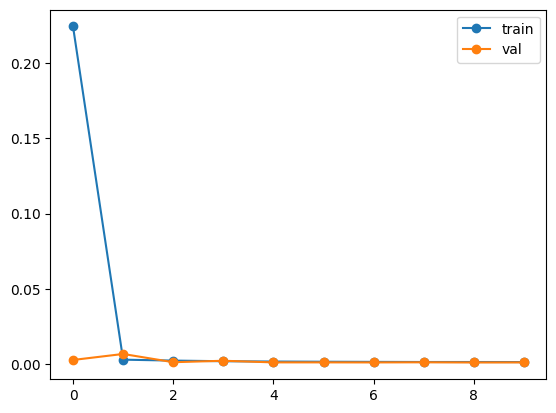

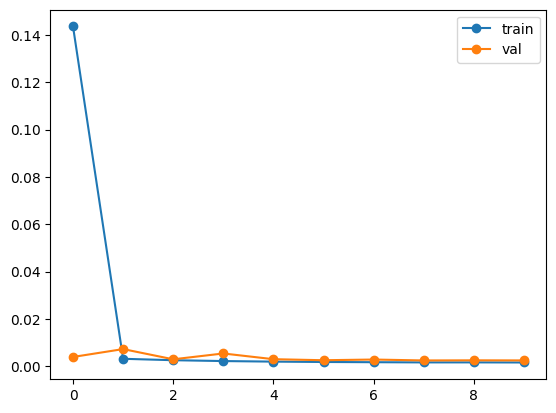

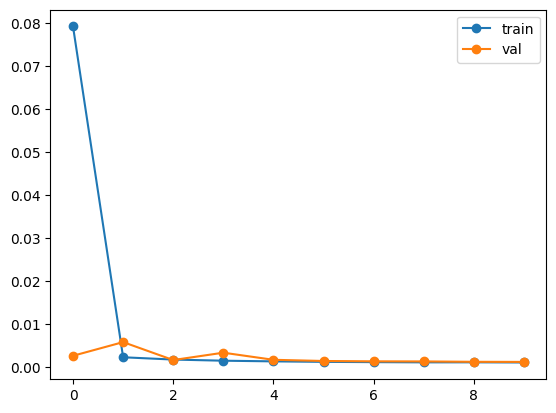

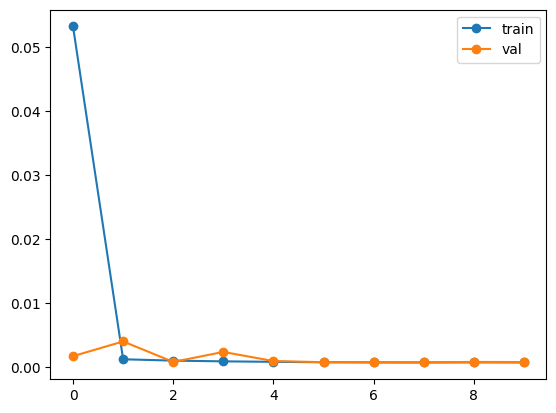

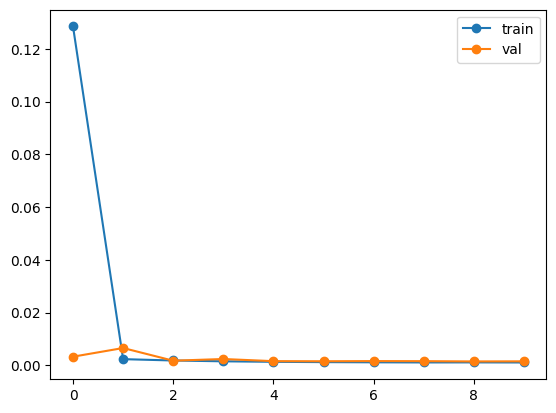

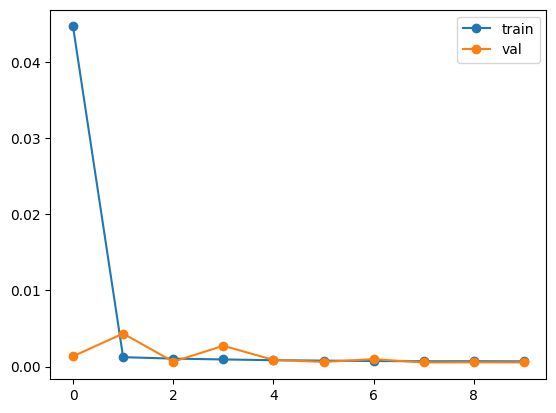

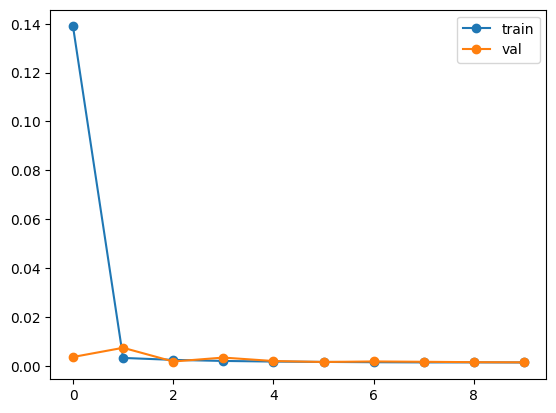

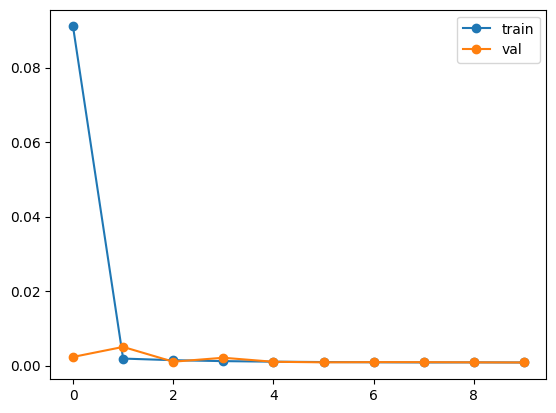

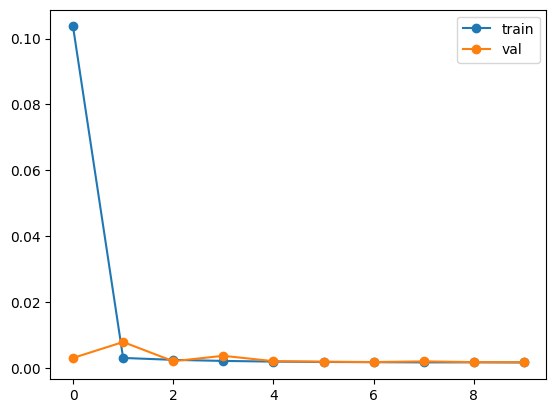

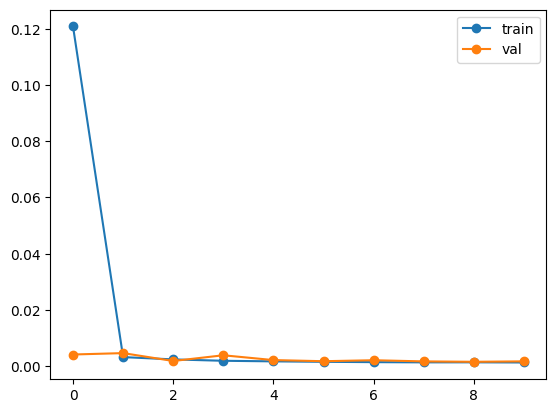

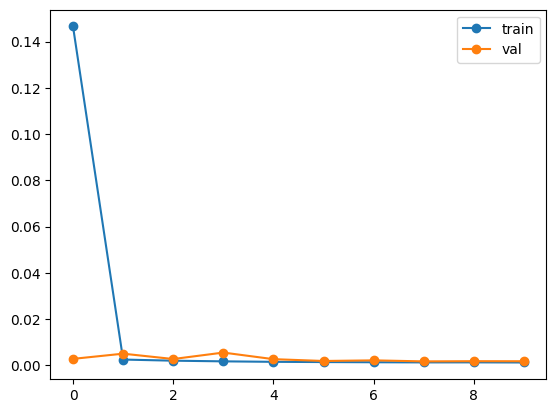

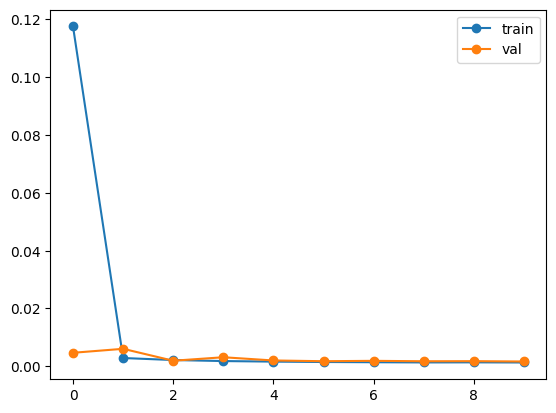

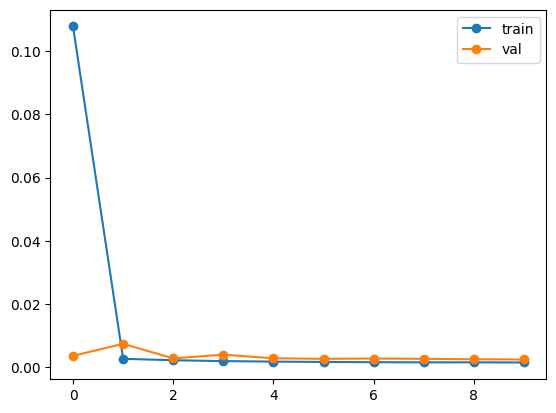

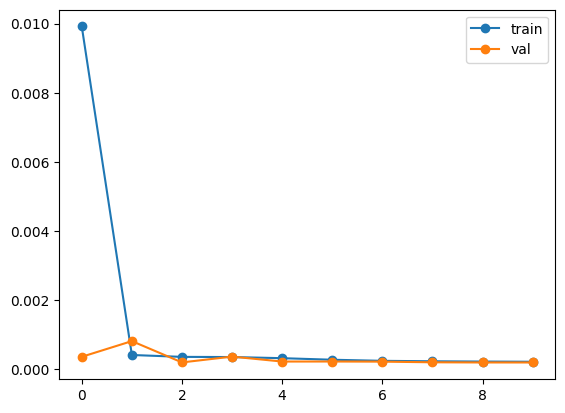


[Epoch    11 of 100] loss_1: 0.001307 val_loss_1: 0.000932 loss_2: 0.001578 val_loss_2: 0.002545 loss_3: 0.001074 val_loss_3: 0.001302 loss_4: 0.000750 val_loss_4: 0.000921 loss_5: 0.001058 val_loss_5: 0.001447 loss_6: 0.000687 val_loss_6: 0.000638 loss_7: 0.001353 val_loss_7: 0.001472 loss_8: 0.000828 val_loss_8: 0.000899 loss_9: 0.001607 val_loss_9: 0.001776 loss_10: 0.001338 val_loss_10: 0.001593 loss_11: 0.001269 val_loss_11: 0.001861 loss_12: 0.001301 val_loss_12: 0.001603 loss_13: 0.001563 val_loss_13: 0.002518 loss_14: 0.000223 val_loss_14: 0.000161
[model_1] Validation loss decreased (0.001057 --> 0.000932).  Saving model ...
[model_2] EarlyStopping counter: 3 out of 5
[model_3] EarlyStopping counter: 1 out of 5
[model_4] EarlyStopping counter: 4 out of 5
[model_5] Validation loss decreased (0.001479 --> 0.001447).  Saving model ...
[model_6] EarlyStopping counter: 3 out of 5
[model_7] EarlyStopping counter: 1 out of 5
[model_8] EarlyStopping counter: 1 out of 5
[model_9] Earl

Early stopping - model_2
Early stopping - model_4
Early stopping - model_6
Early stopping - model_14

[Epoch    17 of 100] loss_1: 0.001116 val_loss_1: 0.001405 loss_2: 0.001367 val_loss_2: 0.002238 loss_3: 0.000962 val_loss_3: 0.001034 loss_4: 0.000708 val_loss_4: 0.001040 loss_5: 0.000906 val_loss_5: 0.001737 loss_6: 0.000616 val_loss_6: 0.000686 loss_7: 0.001153 val_loss_7: 0.001526 loss_8: 0.000700 val_loss_8: 0.001246 loss_9: 0.001421 val_loss_9: 0.001703 loss_10: 0.001092 val_loss_10: 0.001572 loss_11: 0.001134 val_loss_11: 0.001823 loss_12: 0.001162 val_loss_12: 0.002170 loss_13: 0.001407 val_loss_13: 0.002723 loss_14: 0.000199 val_loss_14: 0.000215
[model_1] EarlyStopping counter: 3 out of 5
[model_2] Validation loss decreased (0.002344 --> 0.002238).  Saving model ...
[model_3] Validation loss decreased (0.001139 --> 0.001034).  Saving model ...
[model_4] EarlyStopping counter: 10 out of 5
[model_5] EarlyStopping counter: 3 out of 5
[model_6] EarlyStopping counter: 9 out of 5


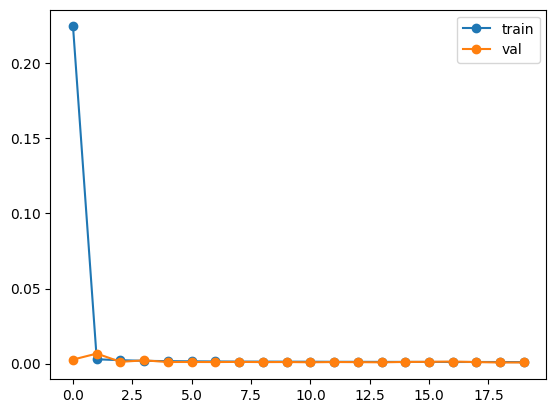

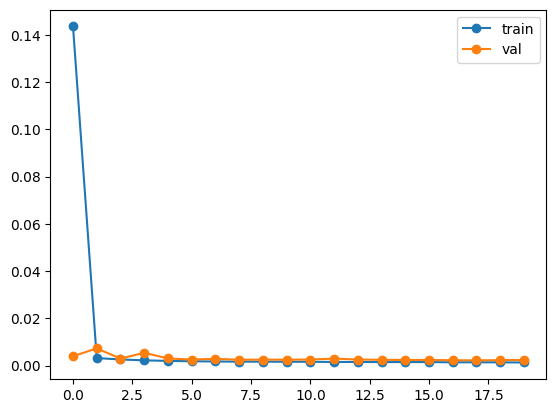

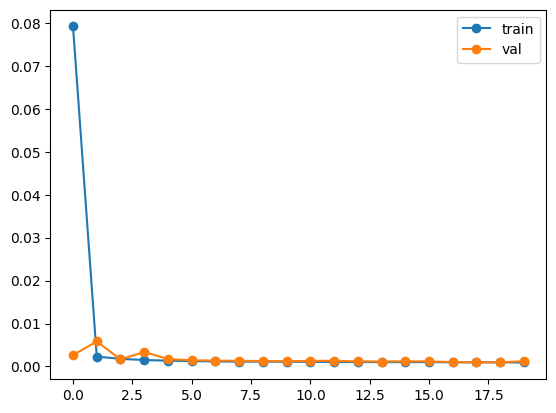

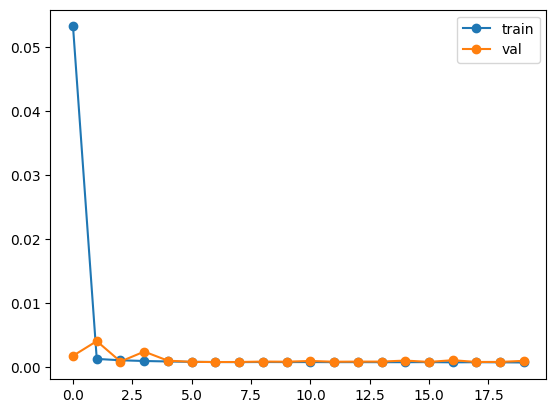

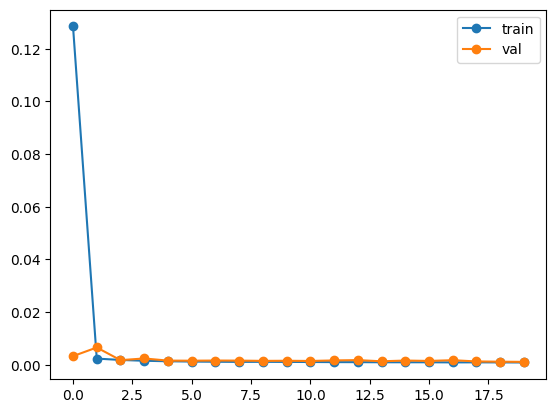

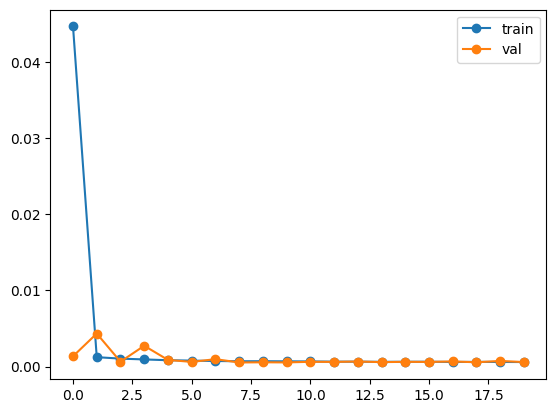

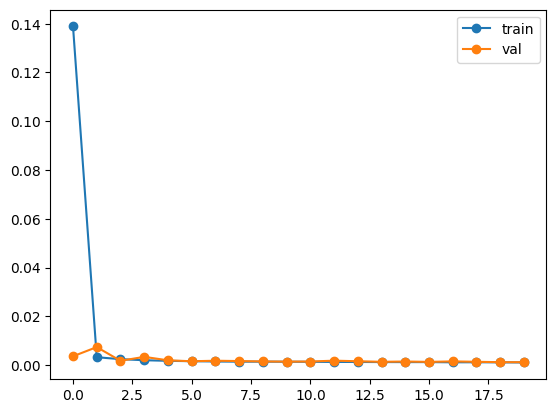

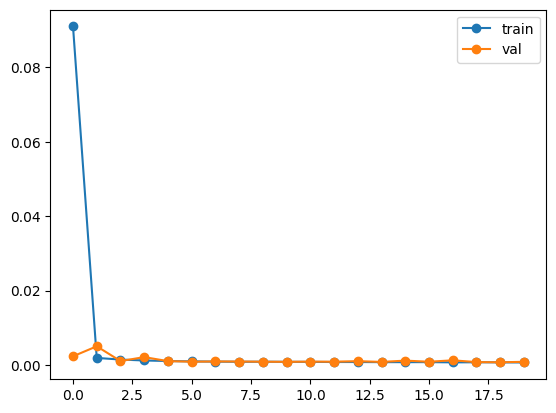

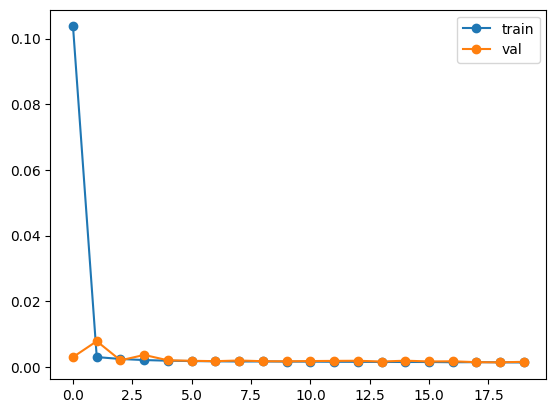

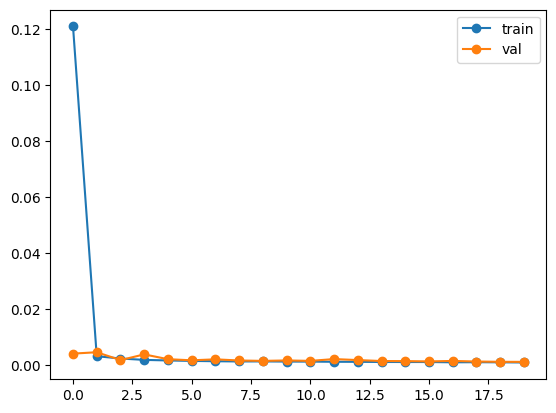

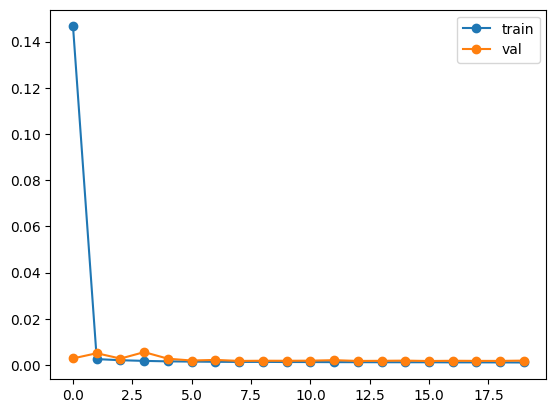

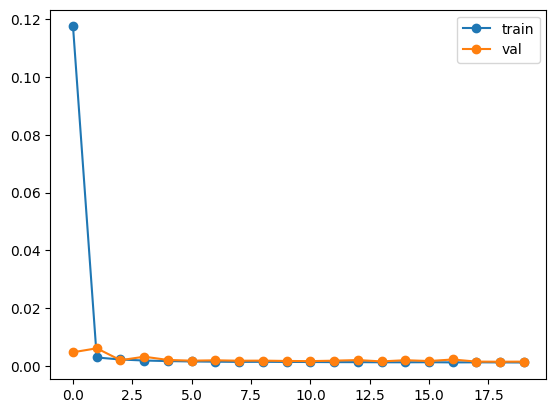

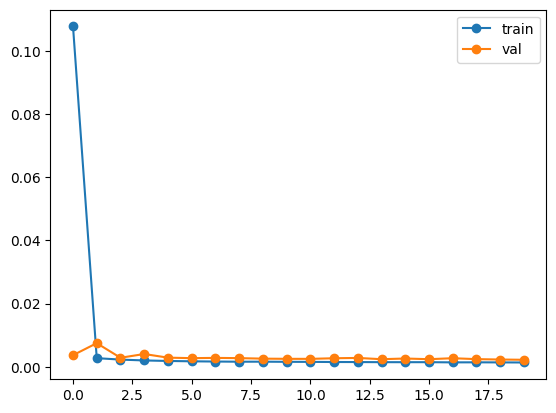

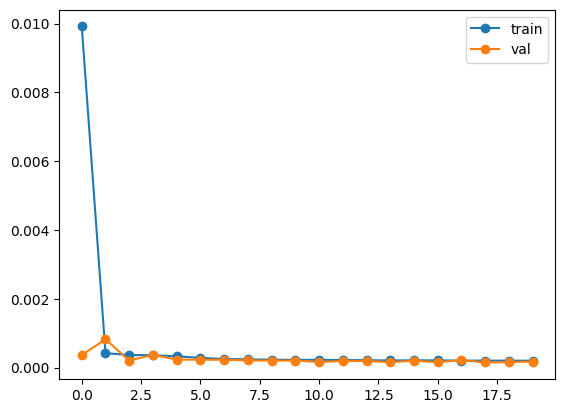


[Epoch    21 of 100] loss_1: 0.001077 val_loss_1: 0.000884 loss_2: 0.001329 val_loss_2: 0.002148 loss_3: 0.000957 val_loss_3: 0.000958 loss_4: 0.000709 val_loss_4: 0.000840 loss_5: 0.000896 val_loss_5: 0.001129 loss_6: 0.000620 val_loss_6: 0.000558 loss_7: 0.001113 val_loss_7: 0.001394 loss_8: 0.000691 val_loss_8: 0.000813 loss_9: 0.001379 val_loss_9: 0.001420 loss_10: 0.001078 val_loss_10: 0.001218 loss_11: 0.001091 val_loss_11: 0.001686 loss_12: 0.001160 val_loss_12: 0.001382 loss_13: 0.001386 val_loss_13: 0.002239 loss_14: 0.000198 val_loss_14: 0.000197
[model_1] EarlyStopping counter: 2 out of 5
[model_2] Validation loss decreased (0.002189 --> 0.002148).  Saving model ...
[model_3] EarlyStopping counter: 3 out of 5
[model_4] EarlyStopping counter: 14 out of 5
[model_5] EarlyStopping counter: 1 out of 5
[model_6] EarlyStopping counter: 13 out of 5
[model_7] EarlyStopping counter: 1 out of 5
[model_8] EarlyStopping counter: 2 out of 5
[model_9] EarlyStopping counter: 2 out of 5
[mo

[model_10] EarlyStopping counter: 2 out of 5
[model_11] EarlyStopping counter: 5 out of 5
[model_12] EarlyStopping counter: 1 out of 5
[model_13] EarlyStopping counter: 2 out of 5
[model_14] EarlyStopping counter: 8 out of 5
Early stopping - model_1
Early stopping - model_2
Early stopping - model_3
Early stopping - model_4
Early stopping - model_6
Early stopping - model_8
Early stopping - model_11
Early stopping - model_14

[Epoch    27 of 100] loss_1: 0.000956 val_loss_1: 0.000736 loss_2: 0.001179 val_loss_2: 0.002116 loss_3: 0.000865 val_loss_3: 0.000918 loss_4: 0.000629 val_loss_4: 0.000793 loss_5: 0.000772 val_loss_5: 0.001071 loss_6: 0.000586 val_loss_6: 0.000535 loss_7: 0.000971 val_loss_7: 0.001001 loss_8: 0.000607 val_loss_8: 0.000784 loss_9: 0.001229 val_loss_9: 0.001246 loss_10: 0.000925 val_loss_10: 0.001045 loss_11: 0.000991 val_loss_11: 0.001742 loss_12: 0.001049 val_loss_12: 0.001229 loss_13: 0.001304 val_loss_13: 0.002241 loss_14: 0.000181 val_loss_14: 0.000161
[model_1]

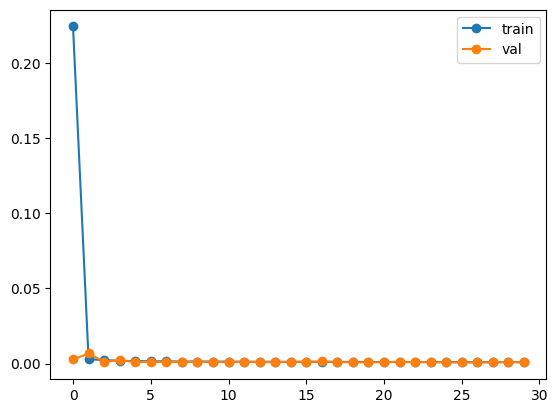

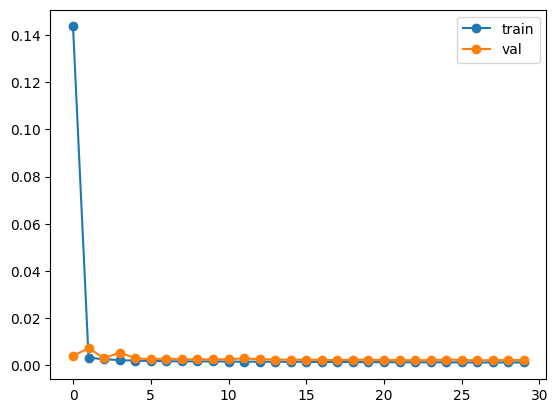

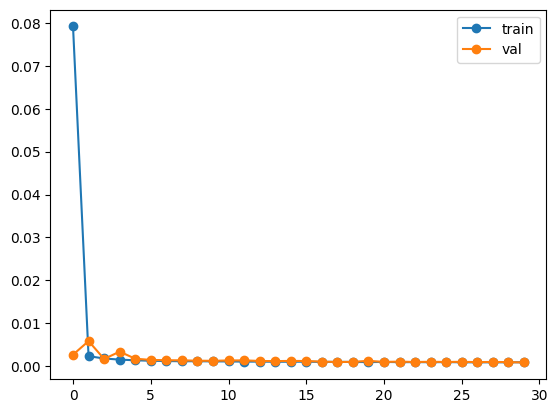

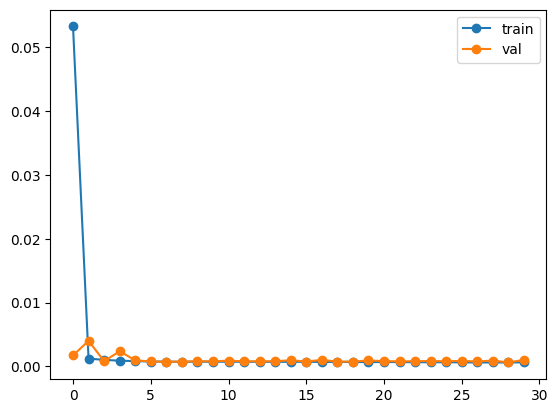

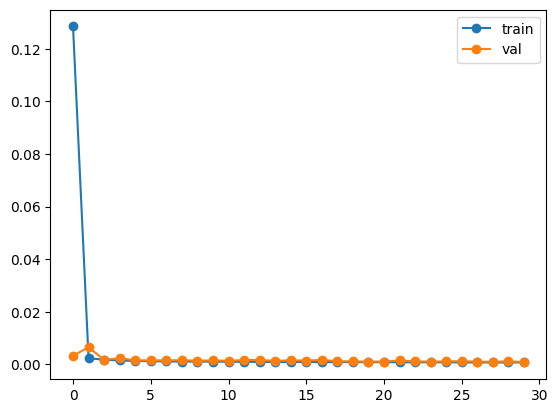

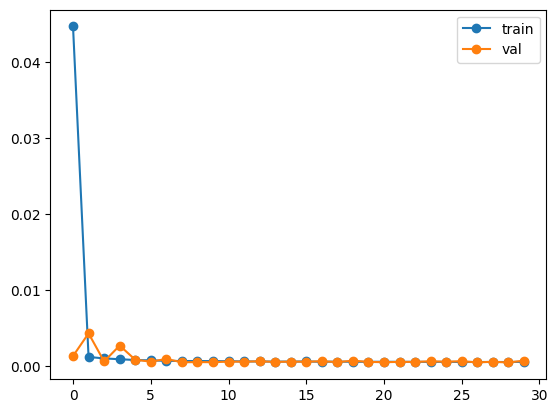

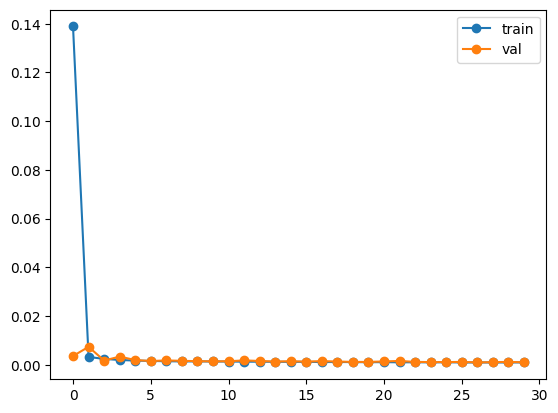

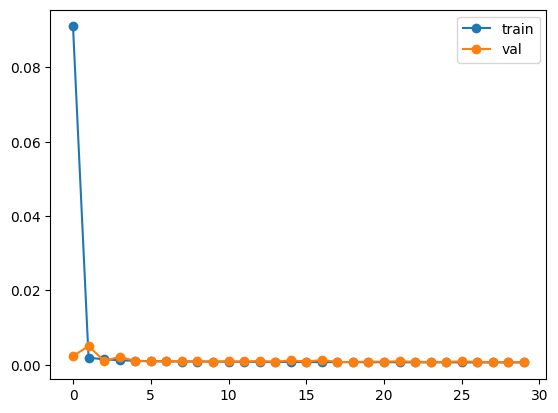

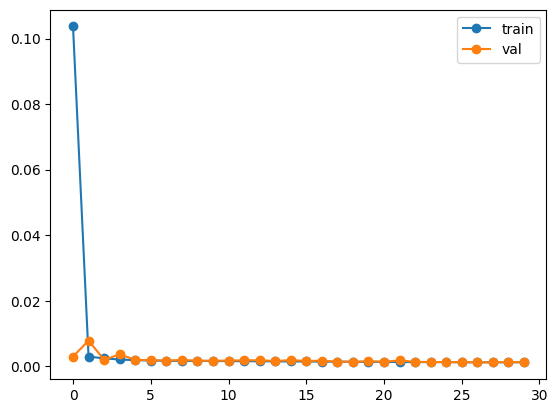

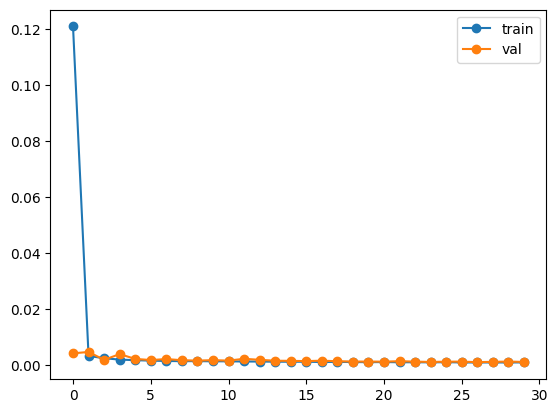

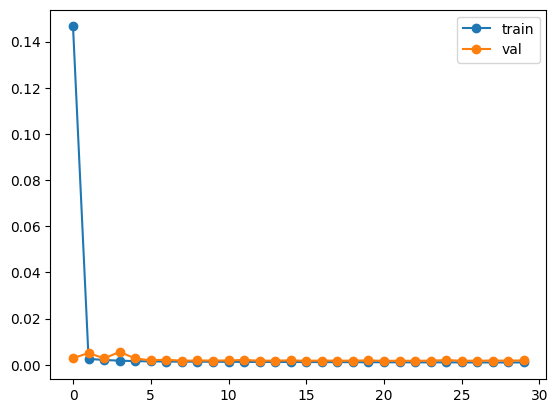

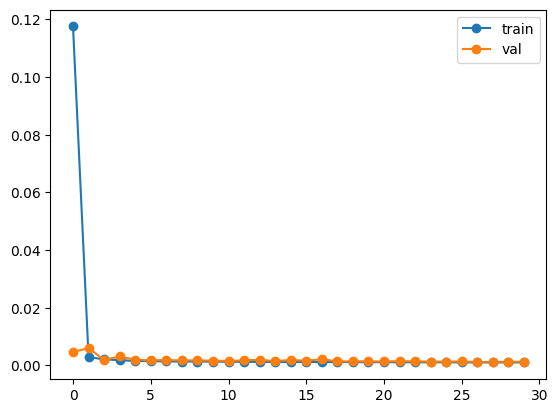

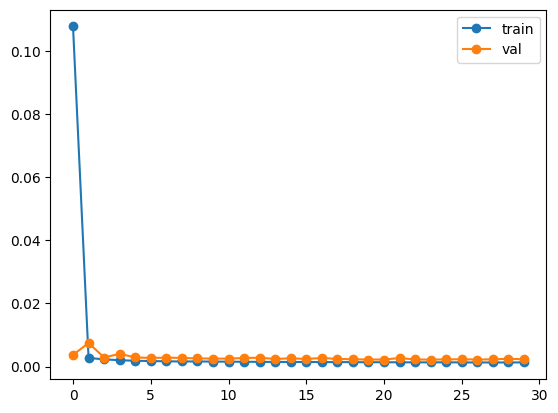

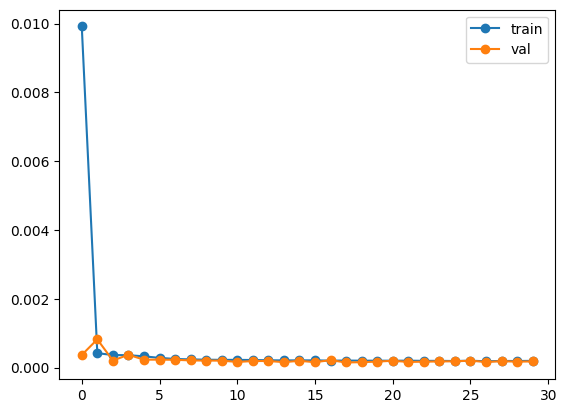


[Epoch    31 of 100] loss_1: 0.000943 val_loss_1: 0.000928 loss_2: 0.001166 val_loss_2: 0.002623 loss_3: 0.000864 val_loss_3: 0.001155 loss_4: 0.000623 val_loss_4: 0.001335 loss_5: 0.000752 val_loss_5: 0.001102 loss_6: 0.000578 val_loss_6: 0.001055 loss_7: 0.000961 val_loss_7: 0.001440 loss_8: 0.000606 val_loss_8: 0.000936 loss_9: 0.001221 val_loss_9: 0.001427 loss_10: 0.000915 val_loss_10: 0.001371 loss_11: 0.000978 val_loss_11: 0.002353 loss_12: 0.001032 val_loss_12: 0.001520 loss_13: 0.001294 val_loss_13: 0.002549 loss_14: 0.000185 val_loss_14: 0.000193
[model_1] EarlyStopping counter: 4 out of 5
[model_2] EarlyStopping counter: 8 out of 5
[model_3] EarlyStopping counter: 1 out of 5
[model_4] EarlyStopping counter: 2 out of 5
[model_5] EarlyStopping counter: 1 out of 5
[model_6] EarlyStopping counter: 2 out of 5
[model_7] EarlyStopping counter: 4 out of 5
[model_8] EarlyStopping counter: 1 out of 5
[model_9] EarlyStopping counter: 3 out of 5
[model_10] EarlyStopping counter: 4 out 


[Epoch    37 of 100] loss_1: 0.000952 val_loss_1: 0.000874 loss_2: 0.001152 val_loss_2: 0.002060 loss_3: 0.000877 val_loss_3: 0.000935 loss_4: 0.000634 val_loss_4: 0.000712 loss_5: 0.000747 val_loss_5: 0.001005 loss_6: 0.000554 val_loss_6: 0.000518 loss_7: 0.000940 val_loss_7: 0.001056 loss_8: 0.000597 val_loss_8: 0.000690 loss_9: 0.001227 val_loss_9: 0.001370 loss_10: 0.000926 val_loss_10: 0.001138 loss_11: 0.000973 val_loss_11: 0.001703 loss_12: 0.001037 val_loss_12: 0.001264 loss_13: 0.001315 val_loss_13: 0.002346 loss_14: 0.000186 val_loss_14: 0.000200
[model_1] EarlyStopping counter: 10 out of 5
[model_2] Validation loss decreased (0.002107 --> 0.002060).  Saving model ...
[model_3] EarlyStopping counter: 7 out of 5
[model_4] EarlyStopping counter: 8 out of 5
[model_5] EarlyStopping counter: 7 out of 5
[model_6] Validation loss decreased (0.000522 --> 0.000518).  Saving model ...
[model_7] EarlyStopping counter: 10 out of 5
[model_8] EarlyStopping counter: 7 out of 5
[model_9] Ea

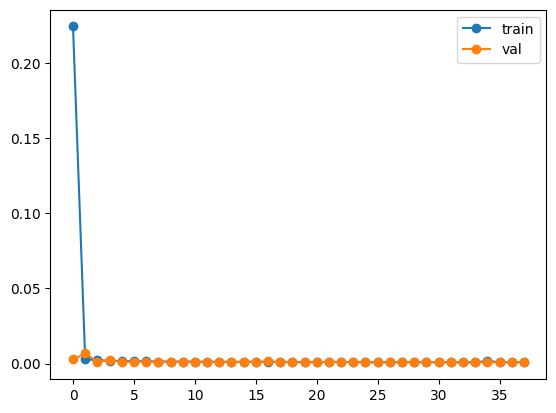

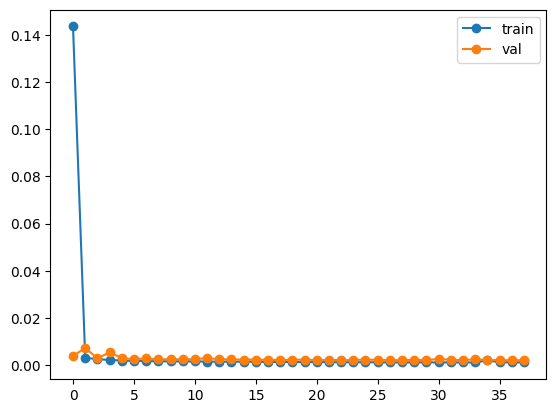

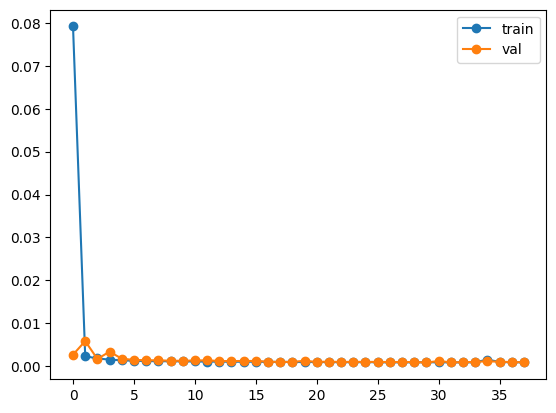

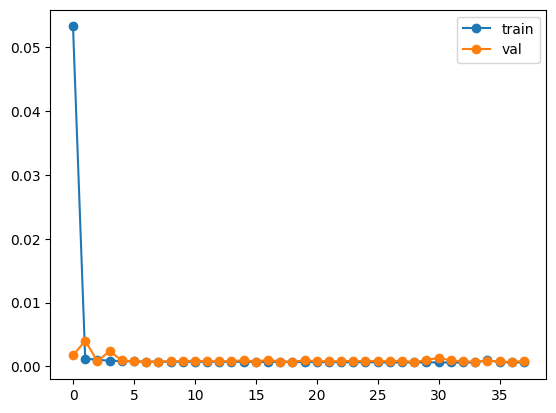

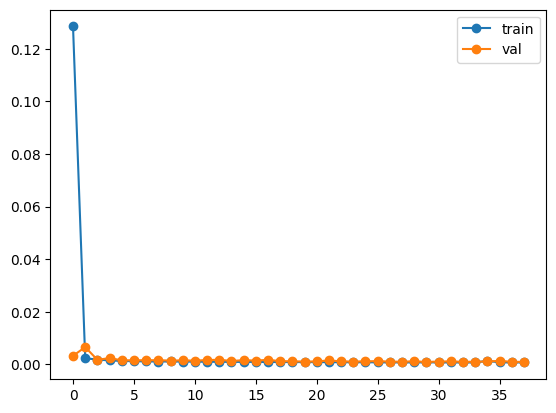

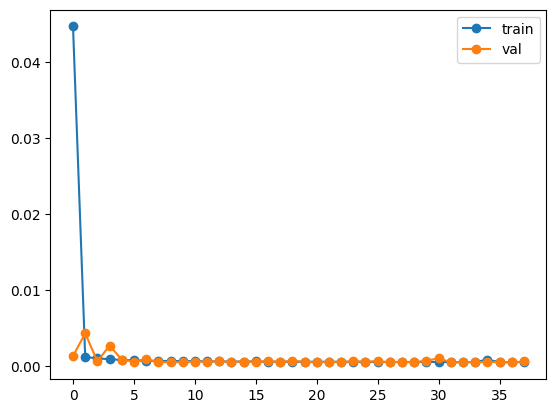

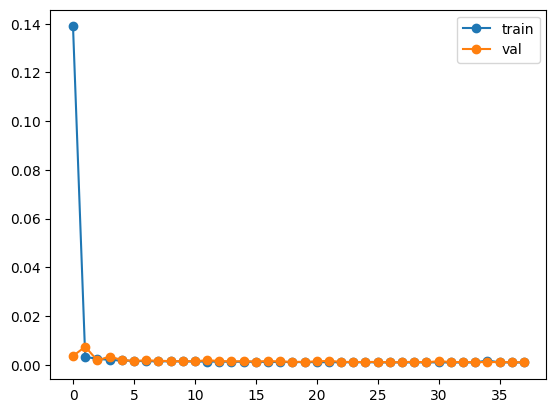

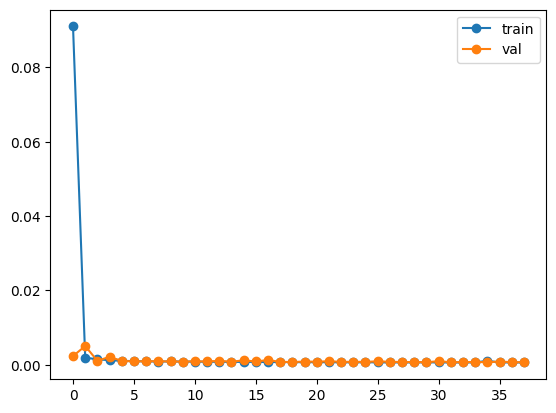

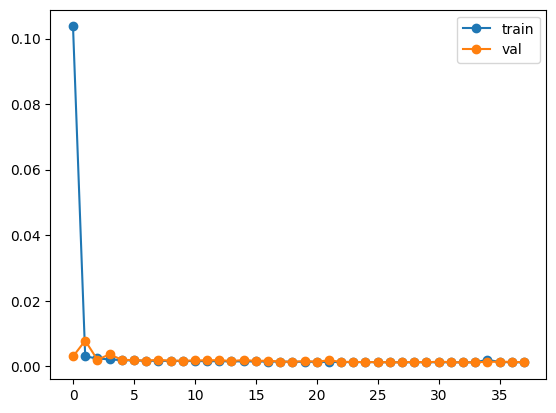

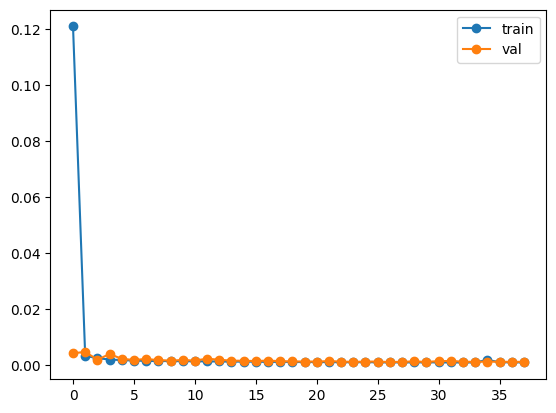

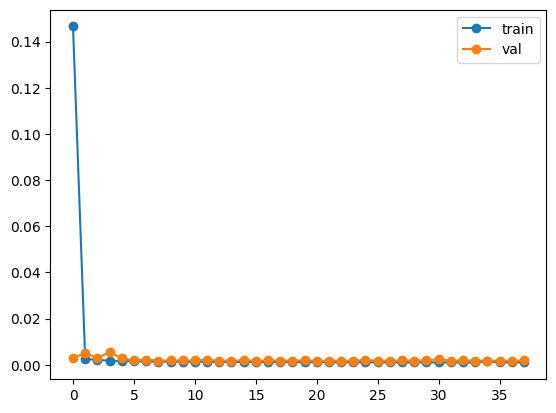

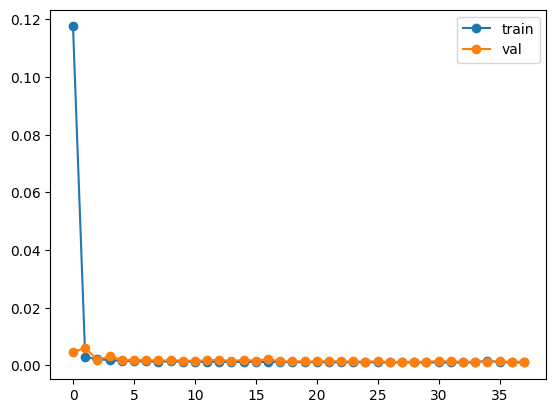

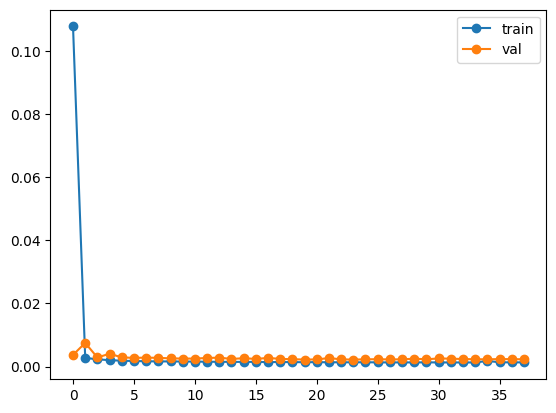

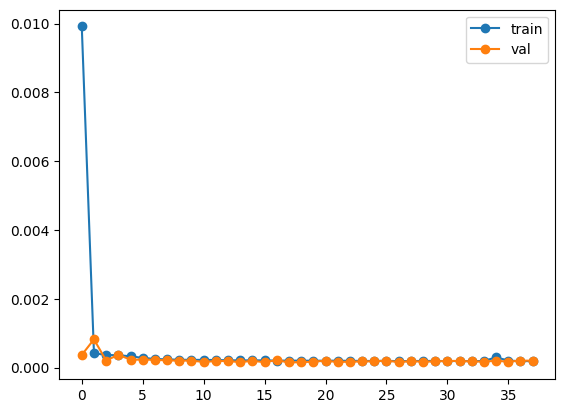


Total time of training: 5.268393570648299 hours


In [51]:
start_time = time.time()

hist_loss_1 = np.zeros(config_args.epochs)
hist_loss_2 = np.zeros(config_args.epochs)
hist_loss_3 = np.zeros(config_args.epochs)
hist_loss_4 = np.zeros(config_args.epochs)
hist_loss_5 = np.zeros(config_args.epochs)
hist_loss_6 = np.zeros(config_args.epochs)
hist_loss_7 = np.zeros(config_args.epochs)
hist_loss_8 = np.zeros(config_args.epochs)
hist_loss_9 = np.zeros(config_args.epochs)
hist_loss_10 = np.zeros(config_args.epochs)
hist_loss_11 = np.zeros(config_args.epochs)
hist_loss_12 = np.zeros(config_args.epochs)
hist_loss_13 = np.zeros(config_args.epochs)
hist_loss_14 = np.zeros(config_args.epochs)

val_hist_loss_1 = np.zeros(config_args.epochs)
val_hist_loss_2 = np.zeros(config_args.epochs)
val_hist_loss_3 = np.zeros(config_args.epochs)
val_hist_loss_4 = np.zeros(config_args.epochs)
val_hist_loss_5 = np.zeros(config_args.epochs)
val_hist_loss_6 = np.zeros(config_args.epochs)
val_hist_loss_7 = np.zeros(config_args.epochs)
val_hist_loss_8 = np.zeros(config_args.epochs)
val_hist_loss_9 = np.zeros(config_args.epochs)
val_hist_loss_10 = np.zeros(config_args.epochs)
val_hist_loss_11 = np.zeros(config_args.epochs)
val_hist_loss_12 = np.zeros(config_args.epochs)
val_hist_loss_13 = np.zeros(config_args.epochs)
val_hist_loss_14 = np.zeros(config_args.epochs)

val_loss_best_1 = np.inf
val_loss_best_2 = np.inf
val_loss_best_3 = np.inf
val_loss_best_4 = np.inf
val_loss_best_5 = np.inf
val_loss_best_6 = np.inf
val_loss_best_7 = np.inf
val_loss_best_8 = np.inf
val_loss_best_9 = np.inf
val_loss_best_10 = np.inf
val_loss_best_11 = np.inf
val_loss_best_12 = np.inf
val_loss_best_13 = np.inf
val_loss_best_14 = np.inf

count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0
count_10 = 0
count_11 = 0
count_12 = 0
count_13 = 0
count_14 = 0

for epoch in range(config_args.epochs):

    # Switching all models in training mode
    model_1.train()
    model_2.train()
    model_3.train()
    model_4.train()
    model_5.train()
    model_6.train()
    model_7.train()
    model_8.train()
    model_9.train()
    model_10.train()
    model_11.train()
    model_12.train()
    model_13.train()
    model_14.train()

    running_loss_1 = 0
    running_loss_2 = 0
    running_loss_3 = 0
    running_loss_4 = 0
    running_loss_5 = 0
    running_loss_6 = 0
    running_loss_7 = 0
    running_loss_8 = 0
    running_loss_9 = 0
    running_loss_10 = 0
    running_loss_11 = 0
    running_loss_12 = 0
    running_loss_13 = 0
    running_loss_14 = 0


    for batch, (categorical_var, continuous_var, target_var) in enumerate(train_dataloader):

        # Setting the gradients to zero
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        optimizer_3.zero_grad()
        optimizer_4.zero_grad()
        optimizer_5.zero_grad()
        optimizer_6.zero_grad()
        optimizer_7.zero_grad()
        optimizer_8.zero_grad()
        optimizer_9.zero_grad()
        optimizer_10.zero_grad()
        optimizer_11.zero_grad()
        optimizer_12.zero_grad()
        optimizer_13.zero_grad()
        optimizer_14.zero_grad()

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)
        zone_4_continuous = copy.deepcopy(continuous_var[:, :, 18:24]).to(device)
        zone_5_continuous = copy.deepcopy(continuous_var[:, :, 24:30]).to(device)
        zone_6_continuous = copy.deepcopy(continuous_var[:, :, 30:36]).to(device)
        zone_7_continuous = copy.deepcopy(continuous_var[:, :, 36:42]).to(device)
        zone_8_continuous = copy.deepcopy(continuous_var[:, :, 42:48]).to(device)
        zone_9_continuous = copy.deepcopy(continuous_var[:, :, 48:54]).to(device)
        zone_10_continuous = copy.deepcopy(continuous_var[:, :, 54:60]).to(device)
        zone_11_continuous = copy.deepcopy(continuous_var[:, :, 60:66]).to(device)
        zone_12_continuous = copy.deepcopy(continuous_var[:, :, 66:72]).to(device)
        zone_13_continuous = copy.deepcopy(continuous_var[:, :, 72:78]).to(device)
        zone_14_continuous = copy.deepcopy(continuous_var[:, :, 78:84]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
        zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
        zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
        zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
        zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
        zone_8_target = copy.deepcopy(target_var[:, :, 7:8])
        zone_9_target = copy.deepcopy(target_var[:, :, 8:9])
        zone_10_target = copy.deepcopy(target_var[:, :, 9:10])
        zone_11_target = copy.deepcopy(target_var[:, :, 10:11])
        zone_12_target = copy.deepcopy(target_var[:, :, 11:12])
        zone_13_target = copy.deepcopy(target_var[:, :, 12:13])
        zone_14_target = copy.deepcopy(target_var[:, :, 13:14])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
        out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
        out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
        out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
        out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
        out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)
        out_vae_9, out_transformer_9 = model_9(common_categorical, zone_9_continuous)
        out_vae_10, out_transformer_10 = model_10(common_categorical, zone_10_continuous)
        out_vae_11, out_transformer_11 = model_11(common_categorical, zone_11_continuous)
        out_vae_12, out_transformer_12 = model_12(common_categorical, zone_12_continuous)
        out_vae_13, out_transformer_13 = model_13(common_categorical, zone_13_continuous)
        out_vae_14, out_transformer_14 = model_14(common_categorical, zone_14_continuous)

        # Calculating the pinball loss
        loss_1 = loss_function(out_transformer_1, zone_1_target.to(device))
        loss_2 = loss_function(out_transformer_2, zone_2_target.to(device))
        loss_3 = loss_function(out_transformer_3, zone_3_target.to(device))
        loss_4 = loss_function(out_transformer_4, zone_4_target.to(device))
        loss_5 = loss_function(out_transformer_5, zone_5_target.to(device))
        loss_6 = loss_function(out_transformer_6, zone_6_target.to(device))
        loss_7 = loss_function(out_transformer_7, zone_7_target.to(device))
        loss_8 = loss_function(out_transformer_8, zone_8_target.to(device))
        loss_9 = loss_function(out_transformer_9, zone_9_target.to(device))
        loss_10 = loss_function(out_transformer_10, zone_10_target.to(device))
        loss_11 = loss_function(out_transformer_11, zone_11_target.to(device))
        loss_12 = loss_function(out_transformer_12, zone_12_target.to(device))
        loss_13 = loss_function(out_transformer_13, zone_13_target.to(device))
        loss_14 = loss_function(out_transformer_14, zone_14_target.to(device))

        # Back-Propagating the loss
        loss_1.backward()
        loss_2.backward()
        loss_3.backward()
        loss_4.backward()
        loss_5.backward()
        loss_6.backward()
        loss_7.backward()
        loss_8.backward()
        loss_9.backward()
        loss_10.backward()
        loss_11.backward()
        loss_12.backward()
        loss_13.backward()
        loss_14.backward()

        # Updating the parameters
        optimizer_1.step()
        optimizer_2.step()
        optimizer_3.step()
        optimizer_4.step()
        optimizer_5.step()
        optimizer_6.step()
        optimizer_7.step()
        optimizer_8.step()
        optimizer_9.step()
        optimizer_10.step()
        optimizer_11.step()
        optimizer_12.step()
        optimizer_13.step()
        optimizer_14.step()

        # Accumulating the running loss
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()
        running_loss_3 += loss_3.item()
        running_loss_4 += loss_4.item()
        running_loss_5 += loss_5.item()
        running_loss_6 += loss_6.item()
        running_loss_7 += loss_7.item()
        running_loss_8 += loss_8.item()
        running_loss_9 += loss_9.item()
        running_loss_10 += loss_10.item()
        running_loss_11 += loss_11.item()
        running_loss_12 += loss_12.item()
        running_loss_13 += loss_13.item()
        running_loss_14 += loss_14.item()

        train_loss_1 = running_loss_1/len(train_dataloader)
        train_loss_2 = running_loss_2/len(train_dataloader)
        train_loss_3 = running_loss_3/len(train_dataloader)
        train_loss_4 = running_loss_4/len(train_dataloader)
        train_loss_5 = running_loss_5/len(train_dataloader)
        train_loss_6 = running_loss_6/len(train_dataloader)
        train_loss_7 = running_loss_7/len(train_dataloader)
        train_loss_8 = running_loss_8/len(train_dataloader)
        train_loss_9 = running_loss_9/len(train_dataloader)
        train_loss_10 = running_loss_10/len(train_dataloader)
        train_loss_11 = running_loss_11/len(train_dataloader)
        train_loss_12 = running_loss_12/len(train_dataloader)
        train_loss_13 = running_loss_13/len(train_dataloader)
        train_loss_14 = running_loss_14/len(train_dataloader)

        val_loss_1 = compute_val_point_score(model_1, test_dataloader,
                                             loss_function, "zone_1",
                                             device).item()
        val_loss_2 = compute_val_point_score(model_2, test_dataloader,
                                             loss_function, "zone_2",
                                             device).item()
        val_loss_3 = compute_val_point_score(model_3, test_dataloader,
                                             loss_function, "zone_3",
                                             device).item()
        val_loss_4 = compute_val_point_score(model_4, test_dataloader,
                                             loss_function, "zone_4",
                                             device).item()
        val_loss_5 = compute_val_point_score(model_5, test_dataloader,
                                             loss_function, "zone_5",
                                             device).item()
        val_loss_6 = compute_val_point_score(model_6, test_dataloader,
                                             loss_function, "zone_6",
                                             device).item()
        val_loss_7 = compute_val_point_score(model_7, test_dataloader,
                                             loss_function, "zone_7",
                                             device).item()
        val_loss_8 = compute_val_point_score(model_8, test_dataloader,
                                             loss_function, "zone_8",
                                             device).item()
        val_loss_9 = compute_val_point_score(model_9, test_dataloader,
                                             loss_function, "zone_9",
                                             device).item()
        val_loss_10 = compute_val_point_score(model_10, test_dataloader,
                                             loss_function, "zone_10",
                                             device).item()
        val_loss_11 = compute_val_point_score(model_11, test_dataloader,
                                             loss_function, "zone_11",
                                             device).item()
        val_loss_12 = compute_val_point_score(model_12, test_dataloader,
                                             loss_function, "zone_12",
                                             device).item()
        val_loss_13 = compute_val_point_score(model_13, test_dataloader,
                                             loss_function, "zone_13",
                                             device).item()
        val_loss_14 = compute_val_point_score(model_14, test_dataloader,
                                             loss_function, "zone_14",
                                             device).item()

        hist_loss_1[epoch] = train_loss_1
        hist_loss_2[epoch] = train_loss_2
        hist_loss_3[epoch] = train_loss_3
        hist_loss_4[epoch] = train_loss_4
        hist_loss_5[epoch] = train_loss_5
        hist_loss_6[epoch] = train_loss_6
        hist_loss_7[epoch] = train_loss_7
        hist_loss_8[epoch] = train_loss_8
        hist_loss_9[epoch] = train_loss_9
        hist_loss_10[epoch] = train_loss_10
        hist_loss_11[epoch] = train_loss_11
        hist_loss_12[epoch] = train_loss_12
        hist_loss_13[epoch] = train_loss_13
        hist_loss_14[epoch] = train_loss_14

        val_hist_loss_1[epoch] = val_loss_1
        val_hist_loss_2[epoch] = val_loss_2
        val_hist_loss_3[epoch] = val_loss_3
        val_hist_loss_4[epoch] = val_loss_4
        val_hist_loss_5[epoch] = val_loss_5
        val_hist_loss_6[epoch] = val_loss_6
        val_hist_loss_7[epoch] = val_loss_7
        val_hist_loss_8[epoch] = val_loss_8
        val_hist_loss_9[epoch] = val_loss_9
        val_hist_loss_10[epoch] = val_loss_10
        val_hist_loss_11[epoch] = val_loss_11
        val_hist_loss_12[epoch] = val_loss_12
        val_hist_loss_13[epoch] = val_loss_13
        val_hist_loss_14[epoch] = val_loss_14
        
    
    print('\n[Epoch {t:5d} of {epochs}] loss_1: {loss_1:1.6f} val_loss_1: {val_loss_1:1.6f} loss_2: {loss_2:1.6f} val_loss_2: {val_loss_2:1.6f} loss_3: {loss_3:1.6f} val_loss_3: {val_loss_3:1.6f} loss_4: {loss_4:1.6f} val_loss_4: {val_loss_4:1.6f} loss_5: {loss_5:1.6f} val_loss_5: {val_loss_5:1.6f} loss_6: {loss_6:1.6f} val_loss_6: {val_loss_6:1.6f} loss_7: {loss_7:1.6f} val_loss_7: {val_loss_7:1.6f} loss_8: {loss_8:1.6f} val_loss_8: {val_loss_8:1.6f} loss_9: {loss_9:1.6f} val_loss_9: {val_loss_9:1.6f} loss_10: {loss_10:1.6f} val_loss_10: {val_loss_10:1.6f} loss_11: {loss_11:1.6f} val_loss_11: {val_loss_11:1.6f} loss_12: {loss_12:1.6f} val_loss_12: {val_loss_12:1.6f} loss_13: {loss_13:1.6f} val_loss_13: {val_loss_13:1.6f} loss_14: {loss_14:1.6f} val_loss_14: {val_loss_14:1.6f}'.format(t=epoch+1,
                                                                                                                                                                                                          epochs=config_args.epochs,
                                                                                                                                                                                                          loss_1=train_loss_1,
                                                                                                                                                                                                          val_loss_1=val_loss_1,
                                                                                                                                                                                                          loss_2=train_loss_2, 
                                                                                                                                                                                                          val_loss_2=val_loss_2,
                                                                                                                                                                                                          loss_3=train_loss_3,
                                                                                                                                                                                                          val_loss_3=val_loss_3,
                                                                                                                                                                                                          loss_4=train_loss_4,
                                                                                                                                                                                                          val_loss_4=val_loss_4,
                                                                                                                                                                                                          loss_5=train_loss_5,
                                                                                                                                                                                                          val_loss_5=val_loss_5,
                                                                                                                                                                                                          loss_6=train_loss_6,
                                                                                                                                                                                                          val_loss_6=val_loss_6,
                                                                                                                                                                                                          loss_7=train_loss_7,
                                                                                                                                                                                                          val_loss_7=val_loss_7,
                                                                                                                                                                                                          loss_8=train_loss_8,
                                                                                                                                                                                                          val_loss_8=val_loss_8,
                                                                                                                                                                                                          loss_9=train_loss_9, 
                                                                                                                                                                                                          val_loss_9=val_loss_9,
                                                                                                                                                                                                          loss_10=train_loss_10,
                                                                                                                                                                                                          val_loss_10=val_loss_10,
                                                                                                                                                                                                          loss_11=train_loss_11,
                                                                                                                                                                                                          val_loss_11=val_loss_11,
                                                                                                                                                                                                          loss_12=train_loss_12,
                                                                                                                                                                                                          val_loss_12=val_loss_12,
                                                                                                                                                                                                          loss_13=train_loss_13,
                                                                                                                                                                                                          val_loss_13=val_loss_13,
                                                                                                                                                                                                          loss_14=train_loss_14,
                                                                                                                                                                                                          val_loss_14=val_loss_14
                                                                                                                                                                                                          ))
    
    # Employing early stopping to avoid overfitting
    early_stopping_1(val_loss_1, model_1)
    early_stopping_2(val_loss_2, model_2)
    early_stopping_3(val_loss_3, model_3)
    early_stopping_4(val_loss_4, model_4)
    early_stopping_5(val_loss_5, model_5)
    early_stopping_6(val_loss_6, model_6)
    early_stopping_7(val_loss_7, model_7)
    early_stopping_8(val_loss_8, model_8)
    early_stopping_9(val_loss_9, model_9)
    early_stopping_10(val_loss_10, model_10)
    early_stopping_11(val_loss_11, model_11)
    early_stopping_12(val_loss_12, model_12)
    early_stopping_13(val_loss_13, model_13)
    early_stopping_14(val_loss_14, model_14)

    if early_stopping_1.early_stop and count_1 < 1:
        print("Early stopping - {}".format(early_stopping_1.model_name))

    if early_stopping_2.early_stop and count_2 < 1:
        print("Early stopping - {}".format(early_stopping_2.model_name))

    if early_stopping_3.early_stop and count_3 < 1:
        print("Early stopping - {}".format(early_stopping_3.model_name))
        
    if early_stopping_4.early_stop and count_4 < 1:
        print("Early stopping - {}".format(early_stopping_4.model_name))

    if early_stopping_5.early_stop and count_5 < 1:
        print("Early stopping - {}".format(early_stopping_5.model_name))

    if early_stopping_6.early_stop and count_6 < 1:
        print("Early stopping - {}".format(early_stopping_6.model_name))
    
    if early_stopping_7.early_stop and count_7 < 1:
        print("Early stopping - {}".format(early_stopping_7.model_name))

    if early_stopping_8.early_stop and count_8 < 1:
        print("Early stopping - {}".format(early_stopping_8.model_name))
        
    if early_stopping_9.early_stop and count_9 < 1:
        print("Early stopping - {}".format(early_stopping_9.model_name))
        
    if early_stopping_10.early_stop and count_10 < 1:
        print("Early stopping - {}".format(early_stopping_10.model_name))

    if early_stopping_11.early_stop and count_11 < 1:
        print("Early stopping - {}".format(early_stopping_11.model_name))

    if early_stopping_12.early_stop and count_12 < 1:
        print("Early stopping - {}".format(early_stopping_12.model_name))
    
    if early_stopping_13.early_stop and count_13 < 1:
        print("Early stopping - {}".format(early_stopping_13.model_name))

    if early_stopping_14.early_stop and count_14 < 1:
        print("Early stopping - {}".format(early_stopping_14.model_name))


    if all((early_stopping_1.early_stop, early_stopping_2.early_stop, early_stopping_3.early_stop, 
            early_stopping_4.early_stop, early_stopping_5.early_stop, early_stopping_6.early_stop,
            early_stopping_7.early_stop, early_stopping_8.early_stop, early_stopping_9.early_stop,
            early_stopping_10.early_stop, early_stopping_11.early_stop, early_stopping_12.early_stop,
            early_stopping_13.early_stop, early_stopping_14.early_stop)):
        print("\nAll model stopped early...")
        break

    if (epoch + 1) % config_args.update_freq == 0:
        print("The plots at epoch {} are:\n".format(epoch+1))
        plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_4, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_4, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_5, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_5, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_6, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_6, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_7, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_7, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_8, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_8, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_9, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_9, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_10, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_10, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_11, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_11, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_12, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_12, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_13, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_13, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_14, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_14, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        
plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_4, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_4, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_5, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_5, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_6, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_6, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_7, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_7, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_8, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_8, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_9, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_9, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_10, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_10, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_11, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_11, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_12, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_12, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_13, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_13, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_14, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_14, 'b'), 'o-', label='val')
plt.legend()
plt.show()

end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [52]:
# Loading the models
best_vae_transformer_1 = load_from_checkpoint(model_1, model_path_1)
best_vae_transformer_2 = load_from_checkpoint(model_2, model_path_2)
best_vae_transformer_3 = load_from_checkpoint(model_3, model_path_3)
best_vae_transformer_4 = load_from_checkpoint(model_4, model_path_4)
best_vae_transformer_5 = load_from_checkpoint(model_5, model_path_5)
best_vae_transformer_6 = load_from_checkpoint(model_6, model_path_6)
best_vae_transformer_7 = load_from_checkpoint(model_7, model_path_7)
best_vae_transformer_8 = load_from_checkpoint(model_8, model_path_8)
best_vae_transformer_9 = load_from_checkpoint(model_9, model_path_9)
best_vae_transformer_10 = load_from_checkpoint(model_10, model_path_10)
best_vae_transformer_11 = load_from_checkpoint(model_11, model_path_11)
best_vae_transformer_12 = load_from_checkpoint(model_12, model_path_12)
best_vae_transformer_13 = load_from_checkpoint(model_13, model_path_13)
best_vae_transformer_14 = load_from_checkpoint(model_14, model_path_14)

In [53]:
point_pred_1 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_2 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_3 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_4 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_5 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_6 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_7 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_8 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_9 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_10 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_11 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_12 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_13 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_14 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
idx_pred_1 = 0
idx_pred_2 = 0
idx_pred_3 = 0
idx_pred_4 = 0
idx_pred_5 = 0
idx_pred_6 = 0
idx_pred_7 = 0
idx_pred_8 = 0
idx_pred_9 = 0
idx_pred_10 = 0
idx_pred_11 = 0
idx_pred_12 = 0
idx_pred_13 = 0
idx_pred_14 = 0

# Switching all models to eval mode
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()
model_5.eval()
model_6.eval()
model_7.eval()
model_8.eval()
model_9.eval()
model_10.eval()
model_11.eval()
model_12.eval()
model_13.eval()
model_14.eval()

with torch.no_grad():
    for (categorical_var, continuous_var, target_var) in tqdm(test_dataloader, total=len(test_dataloader)):

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)
        
        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)
        zone_4_continuous = copy.deepcopy(continuous_var[:, :, 18:24]).to(device)
        zone_5_continuous = copy.deepcopy(continuous_var[:, :, 24:30]).to(device)
        zone_6_continuous = copy.deepcopy(continuous_var[:, :, 30:36]).to(device)
        zone_7_continuous = copy.deepcopy(continuous_var[:, :, 36:42]).to(device)
        zone_8_continuous = copy.deepcopy(continuous_var[:, :, 42:48]).to(device)
        zone_9_continuous = copy.deepcopy(continuous_var[:, :, 48:54]).to(device)
        zone_10_continuous = copy.deepcopy(continuous_var[:, :, 54:60]).to(device)
        zone_11_continuous = copy.deepcopy(continuous_var[:, :, 60:66]).to(device)
        zone_12_continuous = copy.deepcopy(continuous_var[:, :, 66:72]).to(device)
        zone_13_continuous = copy.deepcopy(continuous_var[:, :, 72:78]).to(device)
        zone_14_continuous = copy.deepcopy(continuous_var[:, :, 78:84]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
        zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
        zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
        zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
        zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
        zone_8_target = copy.deepcopy(target_var[:, :, 7:8])
        zone_9_target = copy.deepcopy(target_var[:, :, 8:9])
        zone_10_target = copy.deepcopy(target_var[:, :, 9:10])
        zone_11_target = copy.deepcopy(target_var[:, :, 10:11])
        zone_12_target = copy.deepcopy(target_var[:, :, 11:12])
        zone_13_target = copy.deepcopy(target_var[:, :, 12:13])
        zone_14_target = copy.deepcopy(target_var[:, :, 13:14])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
        out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
        out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
        out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
        out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
        out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)
        out_vae_9, out_transformer_9 = model_9(common_categorical, zone_9_continuous)
        out_vae_10, out_transformer_10 = model_10(common_categorical, zone_10_continuous)
        out_vae_11, out_transformer_11 = model_11(common_categorical, zone_11_continuous)
        out_vae_12, out_transformer_12 = model_12(common_categorical, zone_12_continuous)
        out_vae_13, out_transformer_13 = model_13(common_categorical, zone_13_continuous)
        out_vae_14, out_transformer_14 = model_14(common_categorical, zone_14_continuous)

        # Concatenating the predictions
        point_pred_1[idx_pred_1:idx_pred_1+zone_1_continuous.shape[0]] = out_transformer_1.cpu().numpy()

        point_pred_2[idx_pred_2:idx_pred_2+zone_2_continuous.shape[0]] = out_transformer_2.cpu().numpy()

        point_pred_3[idx_pred_3:idx_pred_3+zone_3_continuous.shape[0]] = out_transformer_3.cpu().numpy()

        point_pred_4[idx_pred_4:idx_pred_4+zone_4_continuous.shape[0]] = out_transformer_4.cpu().numpy()

        point_pred_5[idx_pred_5:idx_pred_5+zone_5_continuous.shape[0]] = out_transformer_5.cpu().numpy()

        point_pred_6[idx_pred_6:idx_pred_6+zone_6_continuous.shape[0]] = out_transformer_6.cpu().numpy()

        point_pred_7[idx_pred_7:idx_pred_7+zone_7_continuous.shape[0]] = out_transformer_7.cpu().numpy()

        point_pred_8[idx_pred_8:idx_pred_8+zone_8_continuous.shape[0]] = out_transformer_8.cpu().numpy()

        point_pred_9[idx_pred_9:idx_pred_9+zone_9_continuous.shape[0]] = out_transformer_9.cpu().numpy()

        point_pred_10[idx_pred_10:idx_pred_10+zone_10_continuous.shape[0]] = out_transformer_10.cpu().numpy()

        point_pred_11[idx_pred_11:idx_pred_11+zone_11_continuous.shape[0]] = out_transformer_11.cpu().numpy()

        point_pred_12[idx_pred_12:idx_pred_12+zone_12_continuous.shape[0]] = out_transformer_12.cpu().numpy()

        point_pred_13[idx_pred_13:idx_pred_13+zone_13_continuous.shape[0]] = out_transformer_13.cpu().numpy()

        point_pred_14[idx_pred_14:idx_pred_14+zone_14_continuous.shape[0]] = out_transformer_14.cpu().numpy()

        idx_pred_1 += zone_1_continuous.shape[0]
        idx_pred_2 += zone_2_continuous.shape[0]
        idx_pred_3 += zone_3_continuous.shape[0]
        idx_pred_4 += zone_4_continuous.shape[0]
        idx_pred_5 += zone_5_continuous.shape[0]
        idx_pred_6 += zone_6_continuous.shape[0]
        idx_pred_7 += zone_7_continuous.shape[0]
        idx_pred_8 += zone_8_continuous.shape[0]
        idx_pred_9 += zone_9_continuous.shape[0]
        idx_pred_10 += zone_10_continuous.shape[0]
        idx_pred_11 += zone_11_continuous.shape[0]
        idx_pred_12 += zone_12_continuous.shape[0]
        idx_pred_13 += zone_13_continuous.shape[0]
        idx_pred_14 += zone_14_continuous.shape[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


#### FORMATTING PREDICTED AND TRUE DATA FOR GENERATING RESULTS

In [54]:
# Reshaping the predicted quantiles
point_pred_arr_1 = point_pred_1.reshape(-1, model_args.d_output)
point_pred_arr_2 = point_pred_2.reshape(-1, model_args.d_output)
point_pred_arr_3 = point_pred_3.reshape(-1, model_args.d_output)
point_pred_arr_4 = point_pred_4.reshape(-1, model_args.d_output)
point_pred_arr_5 = point_pred_5.reshape(-1, model_args.d_output)
point_pred_arr_6 = point_pred_6.reshape(-1, model_args.d_output)
point_pred_arr_7 = point_pred_7.reshape(-1, model_args.d_output)
point_pred_arr_8 = point_pred_8.reshape(-1, model_args.d_output)
point_pred_arr_9 = point_pred_9.reshape(-1, model_args.d_output)
point_pred_arr_10 = point_pred_10.reshape(-1, model_args.d_output)
point_pred_arr_11 = point_pred_11.reshape(-1, model_args.d_output)
point_pred_arr_12 = point_pred_12.reshape(-1, model_args.d_output)
point_pred_arr_13 = point_pred_13.reshape(-1, model_args.d_output)
point_pred_arr_14 = point_pred_14.reshape(-1, model_args.d_output)

point_pred_arr_1.shape

(8760, 1)

In [55]:
point_pred_1_inv = point_pred_arr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
point_pred_2_inv = point_pred_arr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
point_pred_3_inv = point_pred_arr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
point_pred_4_inv = point_pred_arr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
point_pred_5_inv = point_pred_arr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
point_pred_6_inv = point_pred_arr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
point_pred_7_inv = point_pred_arr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
point_pred_8_inv = point_pred_arr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]
point_pred_9_inv = point_pred_arr_9 * (mm_scaler_Y.data_max_[8] - mm_scaler_Y.data_min_[8]) + mm_scaler_Y.data_min_[8]
point_pred_10_inv = point_pred_arr_10 * (mm_scaler_Y.data_max_[9] - mm_scaler_Y.data_min_[9]) + mm_scaler_Y.data_min_[9]
point_pred_11_inv = point_pred_arr_11 * (mm_scaler_Y.data_max_[10] - mm_scaler_Y.data_min_[10]) + mm_scaler_Y.data_min_[10]
point_pred_12_inv = point_pred_arr_12 * (mm_scaler_Y.data_max_[11] - mm_scaler_Y.data_min_[11]) + mm_scaler_Y.data_min_[11]
point_pred_13_inv = point_pred_arr_13 * (mm_scaler_Y.data_max_[12] - mm_scaler_Y.data_min_[12]) + mm_scaler_Y.data_min_[12]
point_pred_14_inv = point_pred_arr_14 * (mm_scaler_Y.data_max_[13] - mm_scaler_Y.data_min_[13]) + mm_scaler_Y.data_min_[13]

point_pred_14_inv.shape

(8760, 1)

In [56]:
# Reshaping the true data
Y_test_1 = target_samples_testing[:, :, 0:1]
Y_test_2 = target_samples_testing[:, :, 1:2]
Y_test_3 = target_samples_testing[:, :, 2:3]
Y_test_4 = target_samples_testing[:, :, 3:4]
Y_test_5 = target_samples_testing[:, :, 4:5]
Y_test_6 = target_samples_testing[:, :, 5:6]
Y_test_7 = target_samples_testing[:, :, 6:7]
Y_test_8 = target_samples_testing[:, :, 7:8]
Y_test_9 = target_samples_testing[:, :, 8:9]
Y_test_10 = target_samples_testing[:, :, 9:10]
Y_test_11 = target_samples_testing[:, :, 10:11]
Y_test_12 = target_samples_testing[:, :, 11:12]
Y_test_13 = target_samples_testing[:, :, 12:13]
Y_test_14 = target_samples_testing[:, :, 13:14]

yArr_1 = Y_test_1.reshape(Y_test_1.shape[0] * Y_test_1.shape[1], Y_test_1.shape[2]).numpy()
yArr_2 = Y_test_2.reshape(Y_test_2.shape[0] * Y_test_2.shape[1], Y_test_2.shape[2]).numpy()
yArr_3 = Y_test_3.reshape(Y_test_3.shape[0] * Y_test_3.shape[1], Y_test_3.shape[2]).numpy()
yArr_4 = Y_test_4.reshape(Y_test_4.shape[0] * Y_test_4.shape[1], Y_test_4.shape[2]).numpy()
yArr_5 = Y_test_5.reshape(Y_test_5.shape[0] * Y_test_5.shape[1], Y_test_5.shape[2]).numpy()
yArr_6 = Y_test_6.reshape(Y_test_6.shape[0] * Y_test_6.shape[1], Y_test_6.shape[2]).numpy()
yArr_7 = Y_test_7.reshape(Y_test_7.shape[0] * Y_test_7.shape[1], Y_test_7.shape[2]).numpy()
yArr_8 = Y_test_8.reshape(Y_test_8.shape[0] * Y_test_8.shape[1], Y_test_8.shape[2]).numpy()
yArr_9 = Y_test_9.reshape(Y_test_9.shape[0] * Y_test_9.shape[1], Y_test_9.shape[2]).numpy()
yArr_10 = Y_test_10.reshape(Y_test_10.shape[0] * Y_test_10.shape[1], Y_test_10.shape[2]).numpy()
yArr_11 = Y_test_11.reshape(Y_test_11.shape[0] * Y_test_11.shape[1], Y_test_11.shape[2]).numpy()
yArr_12 = Y_test_12.reshape(Y_test_12.shape[0] * Y_test_12.shape[1], Y_test_12.shape[2]).numpy()
yArr_13 = Y_test_13.reshape(Y_test_13.shape[0] * Y_test_13.shape[1], Y_test_13.shape[2]).numpy()
yArr_14 = Y_test_14.reshape(Y_test_14.shape[0] * Y_test_14.shape[1], Y_test_14.shape[2]).numpy()

yArr_1.shape

(8760, 1)

In [57]:
yArr_1_inv = yArr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
yArr_2_inv = yArr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
yArr_3_inv = yArr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
yArr_4_inv = yArr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
yArr_5_inv = yArr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
yArr_6_inv = yArr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
yArr_7_inv = yArr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
yArr_8_inv = yArr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]
yArr_9_inv = yArr_9 * (mm_scaler_Y.data_max_[8] - mm_scaler_Y.data_min_[8]) + mm_scaler_Y.data_min_[8]
yArr_10_inv = yArr_10 * (mm_scaler_Y.data_max_[9] - mm_scaler_Y.data_min_[9]) + mm_scaler_Y.data_min_[9]
yArr_11_inv = yArr_11 * (mm_scaler_Y.data_max_[10] - mm_scaler_Y.data_min_[10]) + mm_scaler_Y.data_min_[10]
yArr_12_inv = yArr_12 * (mm_scaler_Y.data_max_[11] - mm_scaler_Y.data_min_[11]) + mm_scaler_Y.data_min_[11]
yArr_13_inv = yArr_13 * (mm_scaler_Y.data_max_[12] - mm_scaler_Y.data_min_[12]) + mm_scaler_Y.data_min_[12]
yArr_14_inv = yArr_14 * (mm_scaler_Y.data_max_[13] - mm_scaler_Y.data_min_[13]) + mm_scaler_Y.data_min_[13]

#### CALCULATING THE MAPE ON TEST DATA

In [58]:
compare_df_1 = pd.DataFrame(data= {"Values": yArr_1_inv[:, 0], "Predictions": point_pred_1_inv[:, 0]})
compare_df_1

,Values,Predictions
0,5851.999512,5470.319678
1,5619.000000,5315.152732
2,5324.000000,5129.231961
3,5273.000000,5151.694057
4,5439.000000,5236.029725
...,...,...
8755,6747.999512,6985.838628
8756,6428.999512,6625.039431
8757,6492.000000,6601.889909
8758,6206.000000,6244.549906


In [59]:
compare_df_2 = pd.DataFrame(data= {"Values": yArr_2_inv[:, 0], "Predictions": point_pred_2_inv[:, 0]})
compare_df_2

,Values,Predictions
0,8542.0,8423.005178
1,8077.0,8184.165312
2,7823.0,8021.286074
3,7636.0,8027.069406
4,7617.0,8157.976821
...,...,...
8755,9369.0,9676.816666
8756,9105.0,9307.580677
8757,9346.0,9404.018448
8758,9392.0,9357.428503


In [60]:
compare_df_3 = pd.DataFrame(data= {"Values": yArr_3_inv[:, 0], "Predictions": point_pred_3_inv[:, 0]})
compare_df_3

,Values,Predictions
0,4133.0,4254.051289
1,3991.0,4161.546298
2,3894.0,3998.323537
3,3841.0,4045.371422
4,3820.0,4155.239408
...,...,...
8755,4760.0,5382.904875
8756,4613.0,5232.717321
8757,4558.0,4954.670427
8758,4410.0,4590.099839


In [61]:
compare_df_4 = pd.DataFrame(data= {"Values": yArr_4_inv[:, 0], "Predictions": point_pred_4_inv[:, 0]})
compare_df_4

,Values,Predictions
0,6545.979980,6682.262439
1,6699.339844,6623.751536
2,6911.950195,6674.603081
3,6840.399902,6556.105231
4,6719.149902,6353.445968
...,...,...
8755,6911.080078,6680.992828
8756,6638.850098,6512.622207
8757,6412.140137,6436.055578
8758,6451.500000,6578.456888


In [62]:
compare_df_5 = pd.DataFrame(data= {"Values": yArr_5_inv[:, 0], "Predictions": point_pred_5_inv[:, 0]})
compare_df_5

,Values,Predictions
0,5677.730469,5351.128829
1,5622.200195,5342.833276
2,5474.740234,5234.807888
3,5432.510254,5201.184018
4,5446.350098,5254.193562
...,...,...
8755,6255.850098,6876.139130
8756,6191.860352,6652.449341
8757,6070.380371,6456.386408
8758,5822.730469,6067.054111


In [63]:
compare_df_6 = pd.DataFrame(data= {"Values": yArr_6_inv[:, 0], "Predictions": point_pred_6_inv[:, 0]})
compare_df_6

,Values,Predictions
0,3186.040039,3186.784851
1,3070.070068,3042.006077
2,2966.189941,2985.032862
3,2933.479980,3038.879331
4,2940.640137,3096.919037
...,...,...
8755,3785.270020,4032.426595
8756,3582.209961,3823.077189
8757,3438.260010,3618.717349
8758,3309.250000,3403.627236


In [64]:
compare_df_7 = pd.DataFrame(data= {"Values": yArr_7_inv[:, 0], "Predictions": point_pred_7_inv[:, 0]})
compare_df_7

,Values,Predictions
0,22699.0,21913.087278
1,21336.0,20962.258079
2,20184.0,20331.707815
3,19430.0,20077.127383
4,19161.0,19953.851180
...,...,...
8755,29362.0,30506.589148
8756,27608.0,29712.802958
8757,25241.0,27691.316913
8758,23911.0,25311.109971


In [65]:
compare_df_8 = pd.DataFrame(data= {"Values": yArr_8_inv[:, 0], "Predictions": point_pred_8_inv[:, 0]})
compare_df_8

,Values,Predictions
0,60301.0,58619.757766
1,58540.0,58667.635764
2,55144.0,56958.933876
3,52978.0,54381.184087
4,52584.0,53812.639547
...,...,...
8755,64771.0,65497.095323
8756,62259.0,62708.799577
8757,63774.0,64042.456514
8758,65865.0,65715.776875


In [66]:
compare_df_9 = pd.DataFrame(data= {"Values": yArr_9_inv[:, 0], "Predictions": point_pred_9_inv[:, 0]})
compare_df_9

,Values,Predictions
0,5225.189941,5230.001193
1,4986.270020,4989.880104
2,4758.820312,4899.252222
3,4580.339844,4818.238820
4,4605.000000,4965.959657
...,...,...
8755,7530.860352,7471.851954
8756,6585.610352,6825.588141
8757,6108.250000,6349.201658
8758,5657.629883,5683.922385


In [67]:
compare_df_10 = pd.DataFrame(data= {"Values": yArr_10_inv[:, 0], "Predictions": point_pred_10_inv[:, 0]})
compare_df_10

,Values,Predictions
0,22850.0,21516.019209
1,21600.0,20667.632427
2,20255.0,20312.373376
3,19459.0,20258.880424
4,19503.0,20423.291658
...,...,...
8755,29746.0,31698.864499
8756,27141.0,29414.512795
8757,25337.0,26847.195945
8758,23876.0,24259.478842


In [68]:
compare_df_11 = pd.DataFrame(data= {"Values": yArr_11_inv[:, 0], "Predictions": point_pred_11_inv[:, 0]})
compare_df_11

,Values,Predictions
0,11194.0,11130.870021
1,10933.0,11014.064236
2,10667.0,10568.883696
3,10413.0,10472.120734
4,10441.0,10576.800223
...,...,...
8755,12799.0,14025.137323
8756,12065.0,13364.327238
8757,11641.0,12658.447123
8758,11418.0,12057.748023


In [69]:
compare_df_12 = pd.DataFrame(data= {"Values": yArr_12_inv[:, 0], "Predictions": point_pred_12_inv[:, 0]})
compare_df_12

,Values,Predictions
0,4796.900391,5151.665101
1,4649.600098,4765.275746
2,4394.400391,4413.607915
3,4176.600098,4240.153683
4,4017.000000,4081.392527
...,...,...
8755,6788.799805,6798.982829
8756,6193.000000,6601.115982
8757,5706.900391,6291.043555
8758,5484.700195,6038.872583


In [70]:
compare_df_13 = pd.DataFrame(data= {"Values": yArr_13_inv[:, 0], "Predictions": point_pred_13_inv[:, 0]})
compare_df_13

,Values,Predictions
0,1053.199951,1058.001321
1,1011.070007,1042.312814
2,963.309998,1052.987901
3,937.859985,1033.206863
4,961.020020,1058.320344
...,...,...
8755,1367.189941,1394.814104
8756,1261.459961,1313.608620
8757,1192.560059,1237.729715
8758,1134.030029,1145.651397


In [71]:
compare_df_14 = pd.DataFrame(data= {"Values": yArr_14_inv[:, 0], "Predictions": point_pred_14_inv[:, 0]})
compare_df_14

,Values,Predictions
0,2744.0,3020.418418
1,2679.0,2900.579231
2,2608.0,2731.659002
3,2602.0,2791.733612
4,2594.0,2933.025688
...,...,...
8755,3080.0,3496.512372
8756,2986.0,3353.791235
8757,2965.0,3187.973491
8758,2980.0,3065.008715


In [72]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_transformer_1, f"vae_transformer_models/L3_vae_transformer_1.pth")
torch.save(best_vae_transformer_2, f"vae_transformer_models/L3_vae_transformer_2.pth")
torch.save(best_vae_transformer_3, f"vae_transformer_models/L3_vae_transformer_3.pth")
torch.save(best_vae_transformer_4, f"vae_transformer_models/L3_vae_transformer_4.pth")
torch.save(best_vae_transformer_5, f"vae_transformer_models/L3_vae_transformer_5.pth")
torch.save(best_vae_transformer_6, f"vae_transformer_models/L3_vae_transformer_6.pth")
torch.save(best_vae_transformer_7, f"vae_transformer_models/L3_vae_transformer_7.pth")
torch.save(best_vae_transformer_8, f"vae_transformer_models/L3_vae_transformer_8.pth")
torch.save(best_vae_transformer_9, f"vae_transformer_models/L3_vae_transformer_9.pth")
torch.save(best_vae_transformer_10, f"vae_transformer_models/L3_vae_transformer_10.pth")
torch.save(best_vae_transformer_11, f"vae_transformer_models/L3_vae_transformer_11.pth")
torch.save(best_vae_transformer_12, f"vae_transformer_models/L3_vae_transformer_12.pth")
torch.save(best_vae_transformer_13, f"vae_transformer_models/L3_vae_transformer_13.pth")
torch.save(best_vae_transformer_14, f"vae_transformer_models/L3_vae_transformer_14.pth")

print("Saved !")

Saving the best trained models.
Saved !


#### EXAMINING THE RESULTS

In [73]:
mape_max_val = mm_scaler_Y.data_max_.max()

New MAPE:  0.25949444222806295
Old MAPE:  2.2748073879779316


<Axes: >

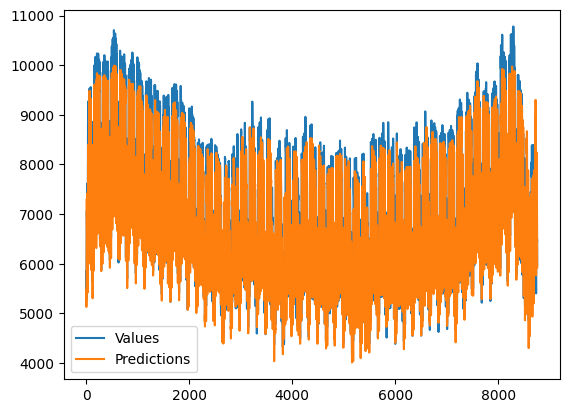

In [74]:
result_mape_1 = new_mape(compare_df_1["Values"], compare_df_1["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_1)
print("Old MAPE: ", mape(compare_df_1["Values"], compare_df_1["Predictions"]))
compare_df_1.plot()

New MAPE:  0.24760933966229307
Old MAPE:  1.7183535343250143


<Axes: >

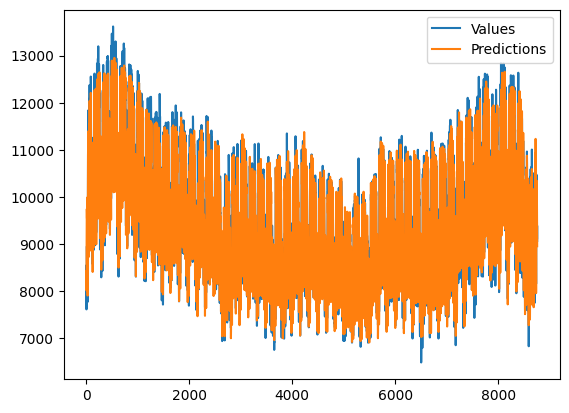

In [75]:
result_mape_2 = new_mape(compare_df_2["Values"], compare_df_2["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_2)
print("Old MAPE: ", mape(compare_df_2["Values"], compare_df_2["Predictions"]))
compare_df_2.plot()

New MAPE:  0.11970074394933906
Old MAPE:  1.5906008574407178


<Axes: >

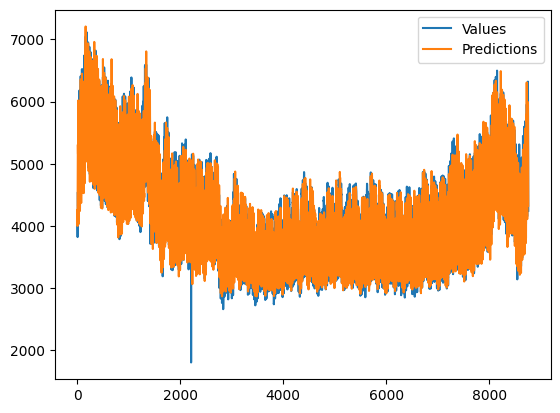

In [76]:
result_mape_3 = new_mape(compare_df_3["Values"], compare_df_3["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_3)
print("Old MAPE: ", mape(compare_df_3["Values"], compare_df_3["Predictions"]))
compare_df_3.plot()

New MAPE:  0.36838913109219623
Old MAPE:  3.550645974134686


<Axes: >

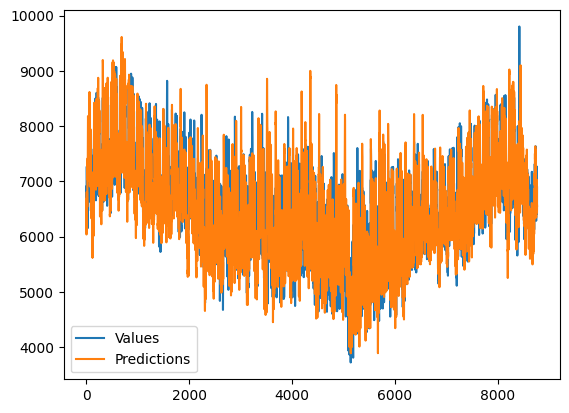

In [77]:
result_mape_4 = new_mape(compare_df_4["Values"], compare_df_4["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_4)
print("Old MAPE: ", mape(compare_df_4["Values"], compare_df_4["Predictions"]))
compare_df_4.plot()

New MAPE:  0.1775688468117241
Old MAPE:  1.5391788793519894


<Axes: >

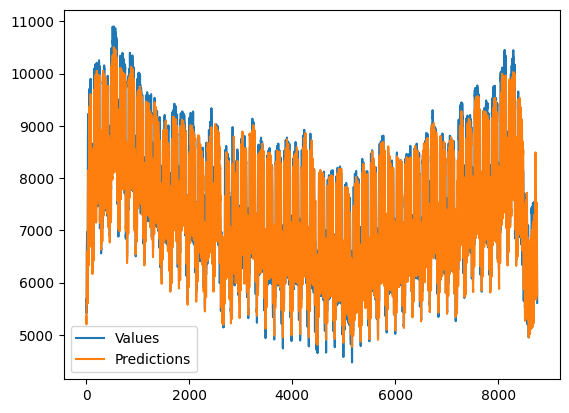

In [78]:
result_mape_5 = new_mape(compare_df_5["Values"], compare_df_5["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_5)
print("Old MAPE: ", mape(compare_df_5["Values"], compare_df_5["Predictions"]))
compare_df_5.plot()

New MAPE:  0.1150741251140065
Old MAPE:  1.6109992580277226


<Axes: >

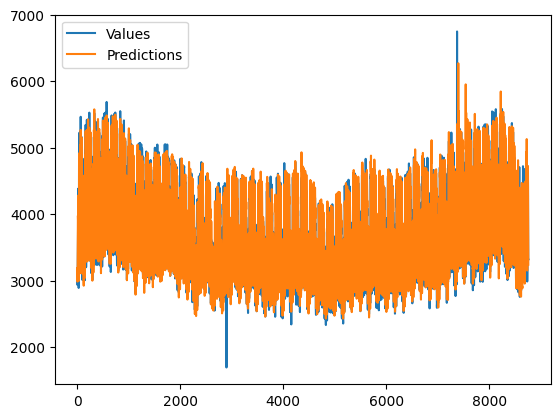

In [79]:
result_mape_6 = new_mape(compare_df_6["Values"], compare_df_6["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_6)
print("Old MAPE: ", mape(compare_df_6["Values"], compare_df_6["Predictions"]))
compare_df_6.plot()

New MAPE:  0.6337379502553312
Old MAPE:  1.4930851570929453


<Axes: >

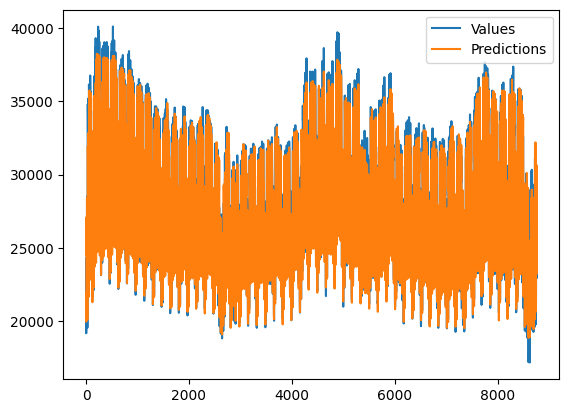

In [80]:
result_mape_7 = new_mape(compare_df_7["Values"], compare_df_7["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_7)
print("Old MAPE: ", mape(compare_df_7["Values"], compare_df_7["Predictions"]))
compare_df_7.plot()

New MAPE:  1.342216770712554
Old MAPE:  1.46892840131769


<Axes: >

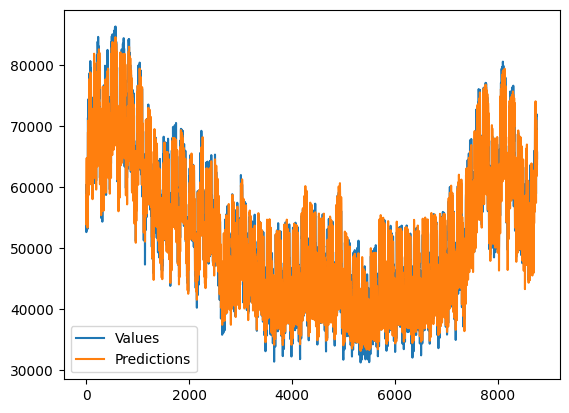

In [81]:
result_mape_8 = new_mape(compare_df_8["Values"], compare_df_8["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_8)
print("Old MAPE: ", mape(compare_df_8["Values"], compare_df_8["Predictions"]))
compare_df_8.plot()

New MAPE:  0.1885716025146211
Old MAPE:  1.8366774005168598


<Axes: >

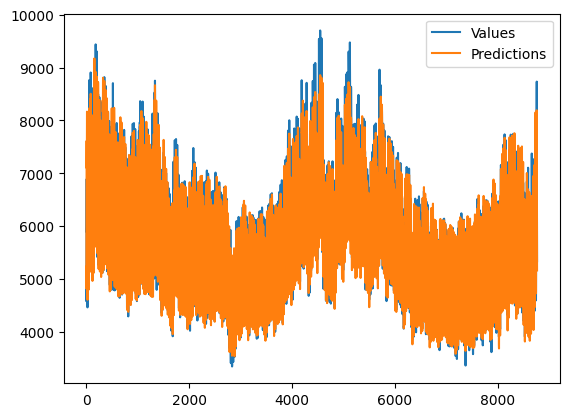

In [82]:
result_mape_9 = new_mape(compare_df_9["Values"], compare_df_9["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_9)
print("Old MAPE: ", mape(compare_df_9["Values"], compare_df_9["Predictions"]))
compare_df_9.plot()

New MAPE:  1.016149137797061
Old MAPE:  1.7839247237054077


<Axes: >

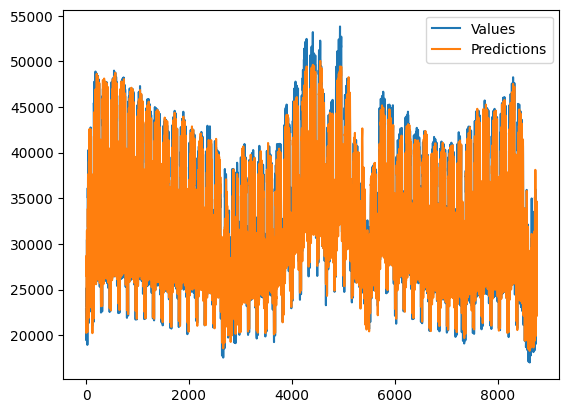

In [83]:
result_mape_10 = new_mape(compare_df_10["Values"], compare_df_10["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_10)
print("Old MAPE: ", mape(compare_df_10["Values"], compare_df_10["Predictions"]))
compare_df_10.plot()

New MAPE:  0.3883250904817384
Old MAPE:  2.036271612086594


<Axes: >

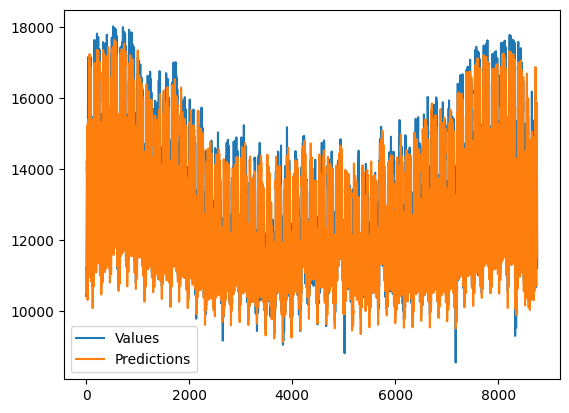

In [84]:
result_mape_11 = new_mape(compare_df_11["Values"], compare_df_11["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_11)
print("Old MAPE: ", mape(compare_df_11["Values"], compare_df_11["Predictions"]))
compare_df_11.plot()

New MAPE:  0.1406114962167627
Old MAPE:  1.552415810497871


<Axes: >

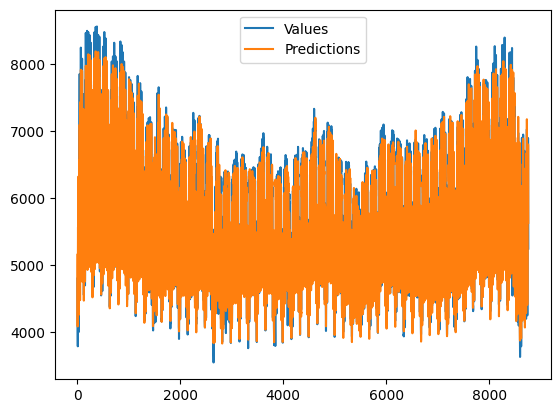

In [85]:
result_mape_12 = new_mape(compare_df_12["Values"], compare_df_12["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_12)
print("Old MAPE: ", mape(compare_df_12["Values"], compare_df_12["Predictions"]))
compare_df_12.plot()

New MAPE:  0.056713877408017185
Old MAPE:  2.2946358328661707


<Axes: >

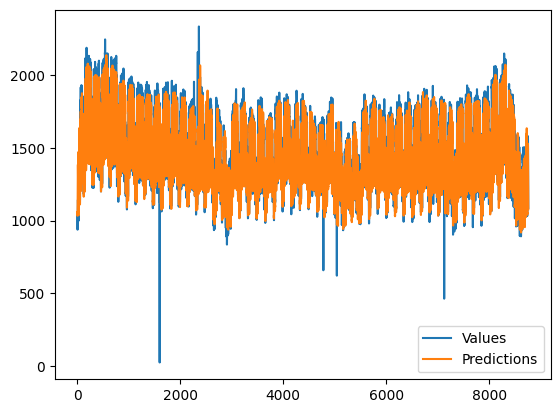

In [86]:
result_mape_13 = new_mape(compare_df_13["Values"], compare_df_13["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_13)
print("Old MAPE: ", mape(compare_df_13["Values"], compare_df_13["Predictions"]))
compare_df_13.plot()

New MAPE:  0.13827255171868294
Old MAPE:  2.598061236230222


<Axes: >

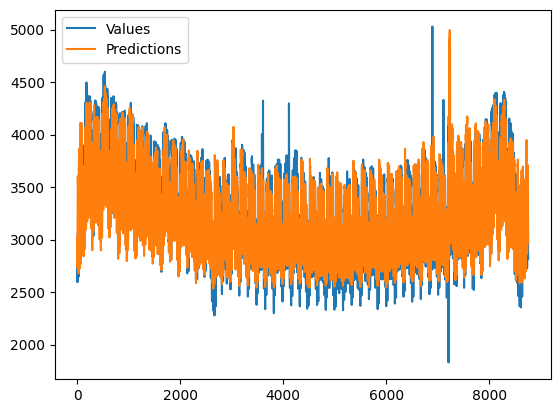

In [87]:
result_mape_14 = new_mape(compare_df_14["Values"], compare_df_14["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_14)
print("Old MAPE: ", mape(compare_df_14["Values"], compare_df_14["Predictions"]))
compare_df_14.plot()

In [88]:
resultsDf = pd.DataFrame()
resultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
resultsDf["mape"] = [
result_mape_1, result_mape_2, result_mape_3,
result_mape_4, result_mape_5, result_mape_6,
result_mape_7, result_mape_8, result_mape_9,
result_mape_10, result_mape_11, result_mape_12,
result_mape_13, result_mape_14
]

resultsDf.to_csv(os.path.join("lag_24_results", dataset + ".csv"), index=False)
print("Results saved !")

Results saved !


In [89]:
resultsDf

,zone,mape
0,AT,0.259494
1,BE,0.247609
2,BG,0.119701
3,CH,0.368389
4,CZ,0.177569
5,DK,0.115074
6,ES,0.633738
7,FR,1.342217
8,GR,0.188572
9,IT,1.016149


In [90]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [91]:
oldResultsDf = pd.DataFrame()
oldResultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
oldResultsDf["mape"] = [
    mape(compare_df_1["Values"], compare_df_1["Predictions"]), 
    mape(compare_df_2["Values"], compare_df_2["Predictions"]), 
    mape(compare_df_3["Values"], compare_df_3["Predictions"]),
    mape(compare_df_4["Values"], compare_df_4["Predictions"]),
    mape(compare_df_5["Values"], compare_df_5["Predictions"]),
    mape(compare_df_6["Values"], compare_df_6["Predictions"]),
    mape(compare_df_7["Values"], compare_df_7["Predictions"]),
    mape(compare_df_8["Values"], compare_df_8["Predictions"]),
    mape(compare_df_9["Values"], compare_df_9["Predictions"]),
    mape(compare_df_10["Values"], compare_df_10["Predictions"]),
    mape(compare_df_11["Values"], compare_df_11["Predictions"]),
    mape(compare_df_12["Values"], compare_df_12["Predictions"]),
    mape(compare_df_13["Values"], compare_df_13["Predictions"]),
    mape(compare_df_14["Values"], compare_df_14["Predictions"]),
]

oldResultsDf.to_csv(os.path.join("lag_24_results", "old_" + dataset + ".csv"), index=False)
print("Results saved !")

oldResultsDf

Results saved !


,zone,mape
0,AT,2.274807
1,BE,1.718354
2,BG,1.590601
3,CH,3.550646
4,CZ,1.539179
5,DK,1.610999
6,ES,1.493085
7,FR,1.468928
8,GR,1.836677
9,IT,1.783925
